# Discrepancy Calculation and Generating Vector Searches
## for Kronecker and Extensible Lattice Sequences

This notebook demonstrates different uses and visualizations of Kronecker and Lattice sequences using the QMCPy software package.

Author: Jimmy Nguyen (nguyen.hoang.jimmy42@gmail.com)

In [1]:
import qmcpy as qp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar on loops, optional

In [2]:
# Currently, the images are untracked files.
save_figs = True
from pathlib import Path
import os

image_format = 'png'
# directories used to store images (for Overleaf organization purposes)
# main_directory = 'diff_weighted_figures'
main_directory = 'figures'
if save_figs:
    if not os.path.exists(main_directory):
        os.mkdir(main_directory)

    folders = ['samples', 'kronecker', 'lattice', 'both', 'keister', 'asian_option']
    for folder in folders:
        if not os.path.exists(main_directory + '/' + folder):
            os.mkdir(main_directory + '/' + folder)

def save_figure(path, figure):
    if save_figs:
        figure.savefig(Path(f'{main_directory}/{path}.' + image_format), format = image_format)

In [3]:
plt.rcParams["figure.dpi"] = 300

def plot_samples(sampler, n, d_horizontal = 1, d_vertical = 2, marker_size = 5, figfac = 5, axis_pad = 0, font_family = "sans-serif"):
    plt.rcParams['font.family'] = font_family
    plt.rcParams['figure.constrained_layout.use'] = True

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n = np.atleast_1d(n)
    samples = sampler.gen_samples(n[-1])

    fig, ax = plt.subplots(ncols = n.size, figsize = (figfac, figfac * n.size), layout = "constrained")

    for i in range(n.size):
            ax[i].set_xlim([0 - axis_pad, 1 + axis_pad])
            ax[i].set_ylim([0 - axis_pad, 1 + axis_pad])

            ax[i].set_xticks([0, 1/4, 1/2, 3/4, 1])
            ax[i].set_yticks([0, 1/4, 1/2, 3/4, 1])

            ax[i].set_aspect(1)
            ax[i].grid(True)
                
            ax[i].set_xlabel('$x_{i1}$',fontsize = 15)
            ax[i].set_ylabel('$x_{i2}$',fontsize = 15)

            n_min = 0
            for m in range(i + 1):
                n_max = n[m]
                ax[i].scatter(samples[n_min:n_max, 0], samples[n_min:n_max, 1], s = marker_size, color = colors[m])
                n_min = n[m]

    return fig, ax

In [4]:
dimension = 6 
axis_pad = 0.05
marker_size = 15
fig_factor = 10

## IID Sequences

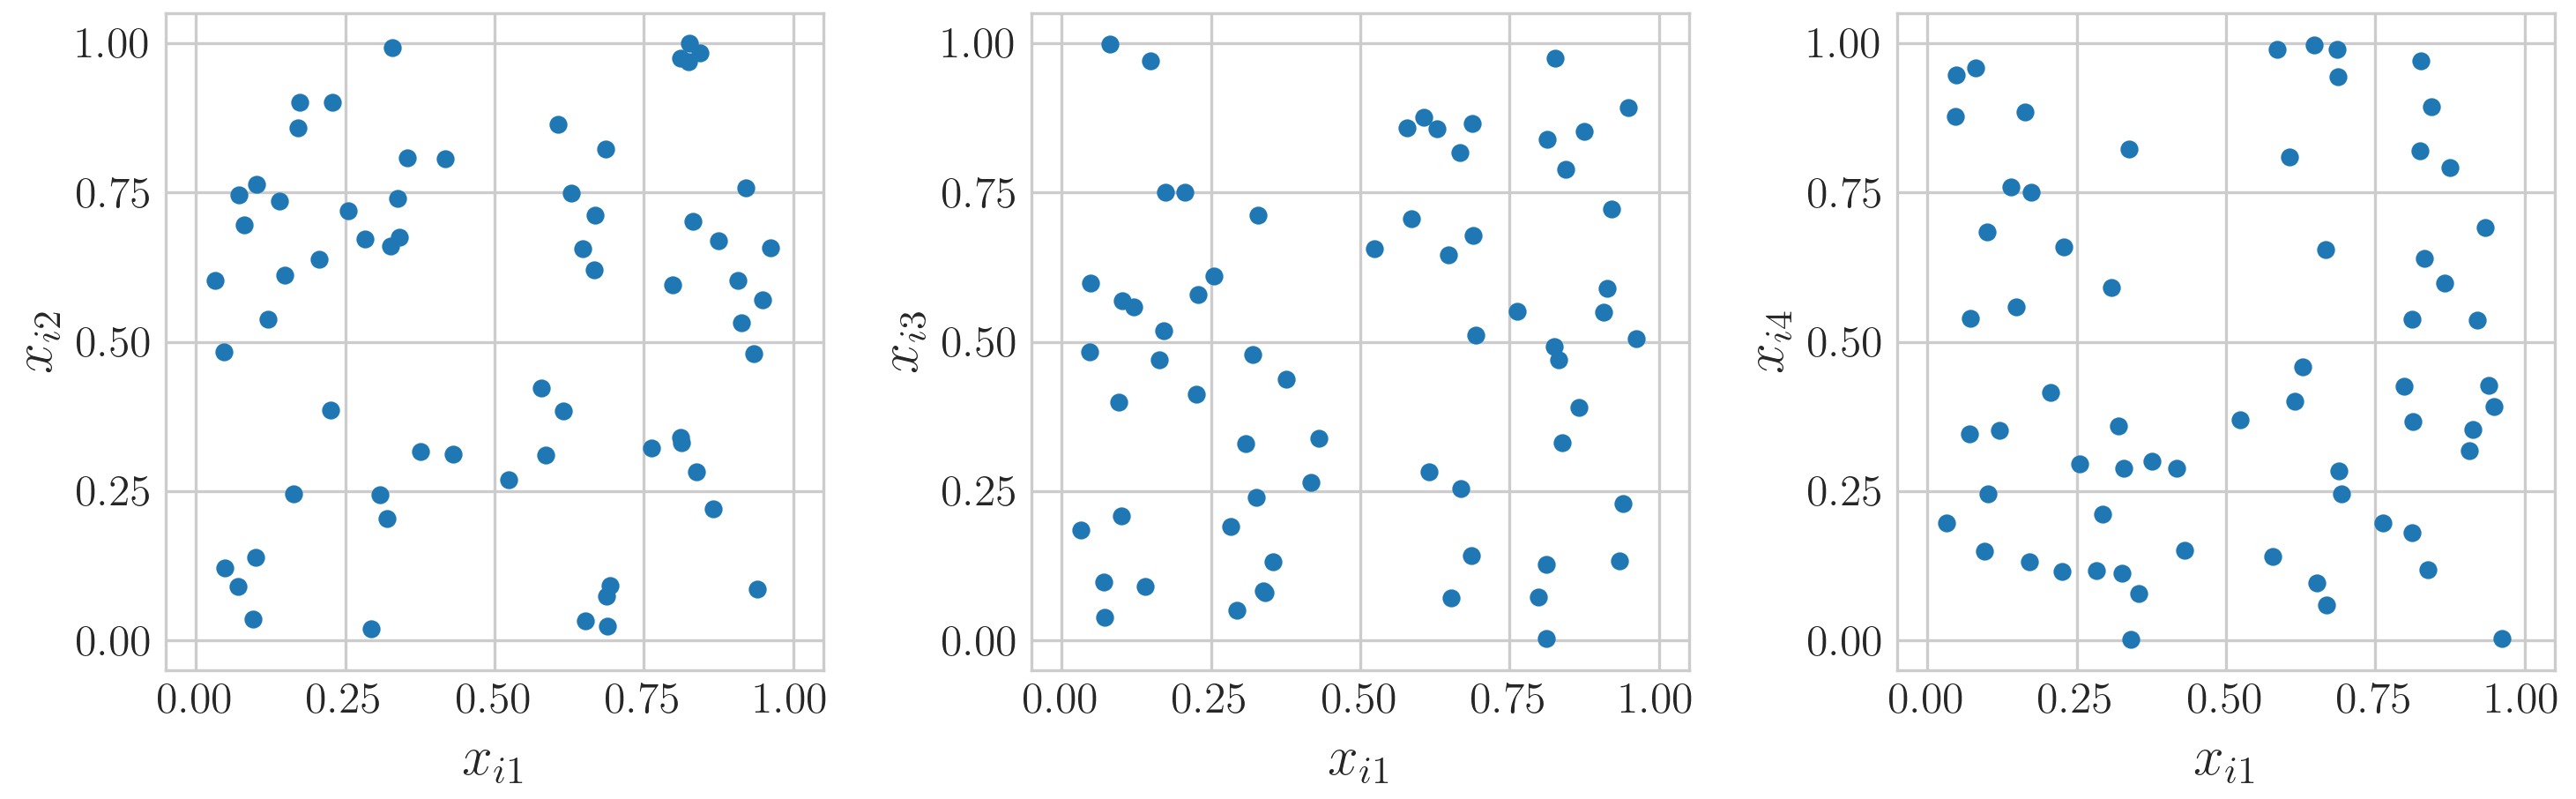

In [5]:
fig, ax = qp.plot_proj(qp.IIDStdUniform(dimension, seed = 24), d_horizontal = np.array([1]), d_vertical = np.arange(2, 5),
                       figfac = fig_factor, axis_pad = axis_pad, marker_size = marker_size, fig_title = '')
save_figure('samples/iid', fig)

# Samples of Low Discrepancy Sequences
## Kronecker Sequences

In [6]:
n_list = [32, 64, 90]

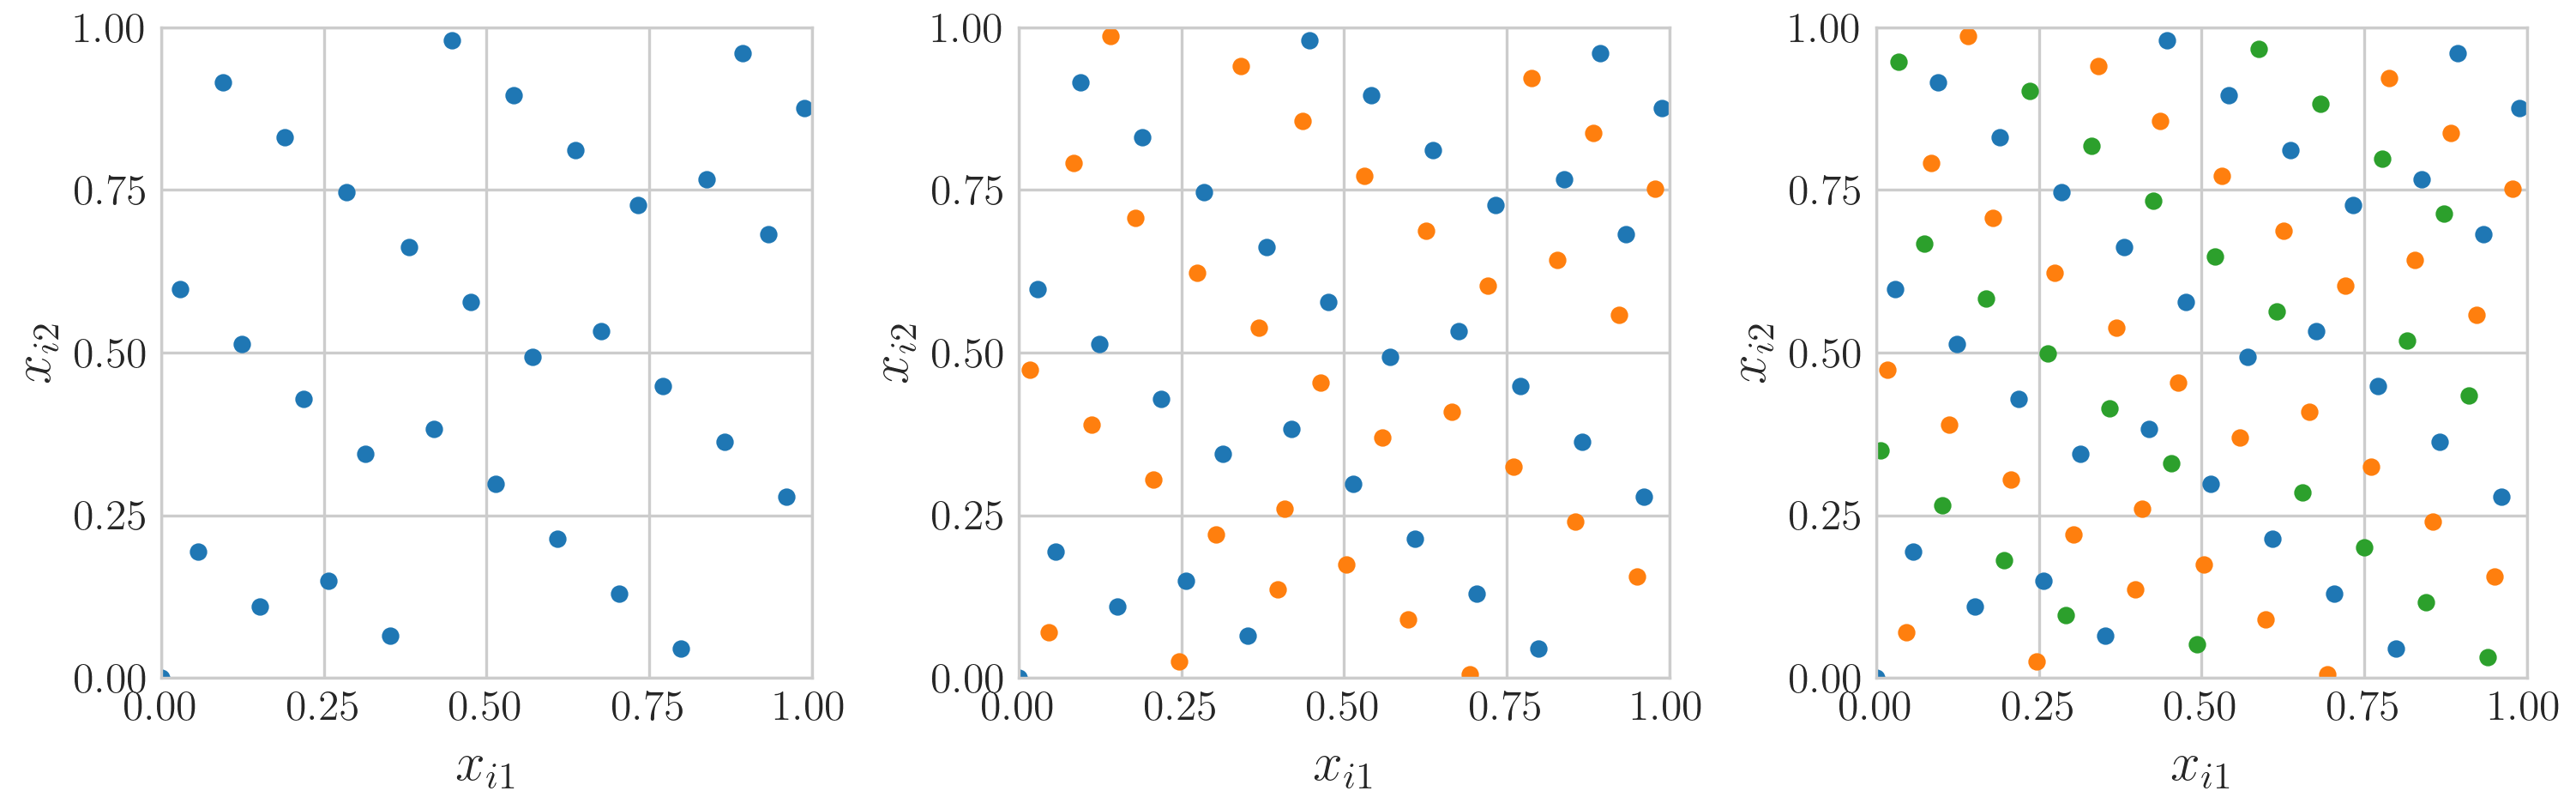

In [7]:
alpha = np.array([0.41900501, 0.38310311, 0.10865909, 0.24084945, 0.17683976, 0.26454], dtype=np.float64)
fig, ax = plot_samples(qp.Kronecker(dimension, alpha), n_list, marker_size = marker_size, figfac = fig_factor)
save_figure('samples/kronecker', fig)

## Lattice Sequences

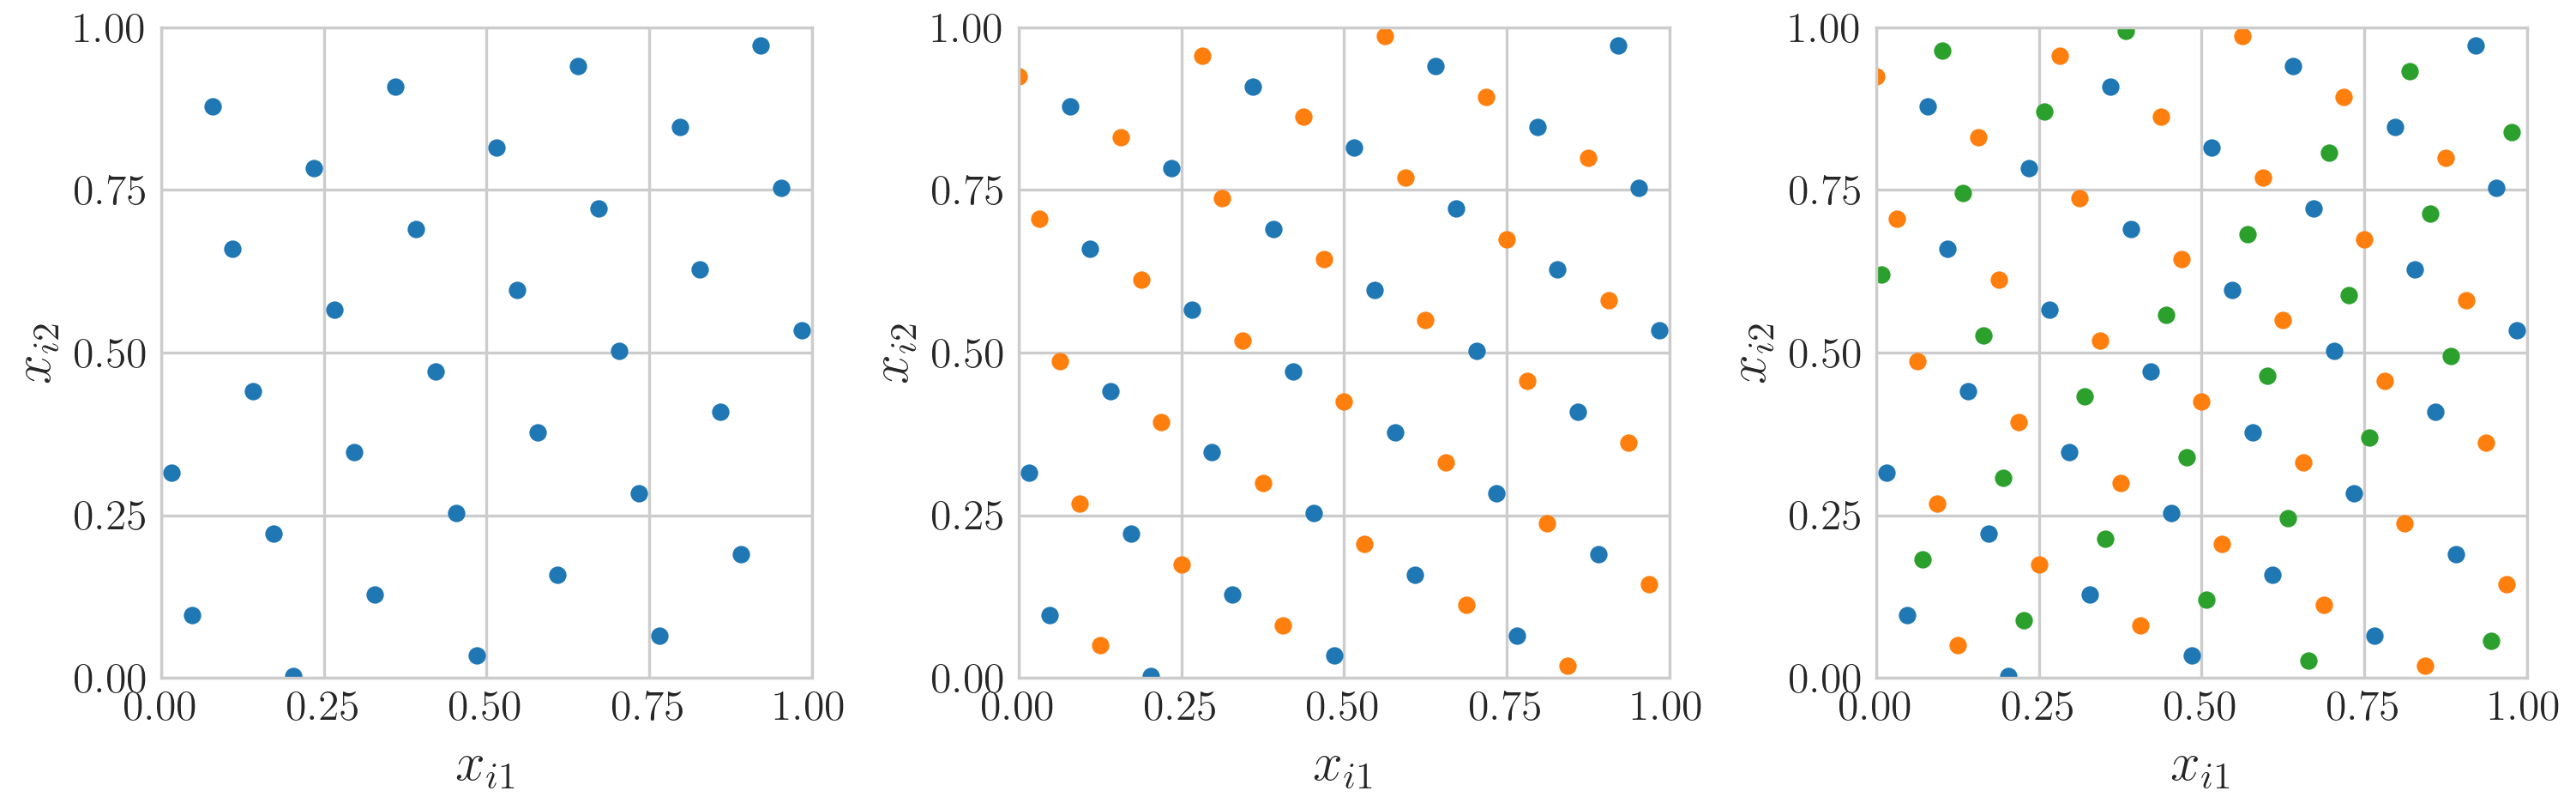

In [8]:
generating_vector = np.array([1, 444633, 468443, 63389, 310317, 297749], dtype=np.uint64)
fig, ax = plot_samples(qp.Lattice(dimension, generating_vector = generating_vector, order = 'gray', d_max=6, m_max=2**20),
                       n_list, marker_size = marker_size, figfac = fig_factor)
save_figure('samples/lattice', fig)

# Comparisons to Other Generating Vectors


In [9]:
dimensions = np.array([5, 50])
axes_size = 28
legend_size = 16
trend_width = 2

## Kronecker: CBC and Richtmyer

In [10]:
# creates a d-length np.array with values 1/l^2
def calculate_gamma(dimension):
    return 1 / (np.arange(1, dimension + 1) ** 2)

We compare the CBC searched $\alpha$ to $\alpha_{\mathrm{Richt}}:= (\sqrt{p_1} \bmod 1, \sqrt{p_2} \bmod1, \dots),$ where $p_{\ell}$ is the $\ell$ th prime.


In [11]:
gammas = [calculate_gamma(dimension) for dimension in dimensions] # coordinate weights
d50_alpha = np.loadtxt(Path('kron_vector/d50_n2^17_1e5alpha.txt'))

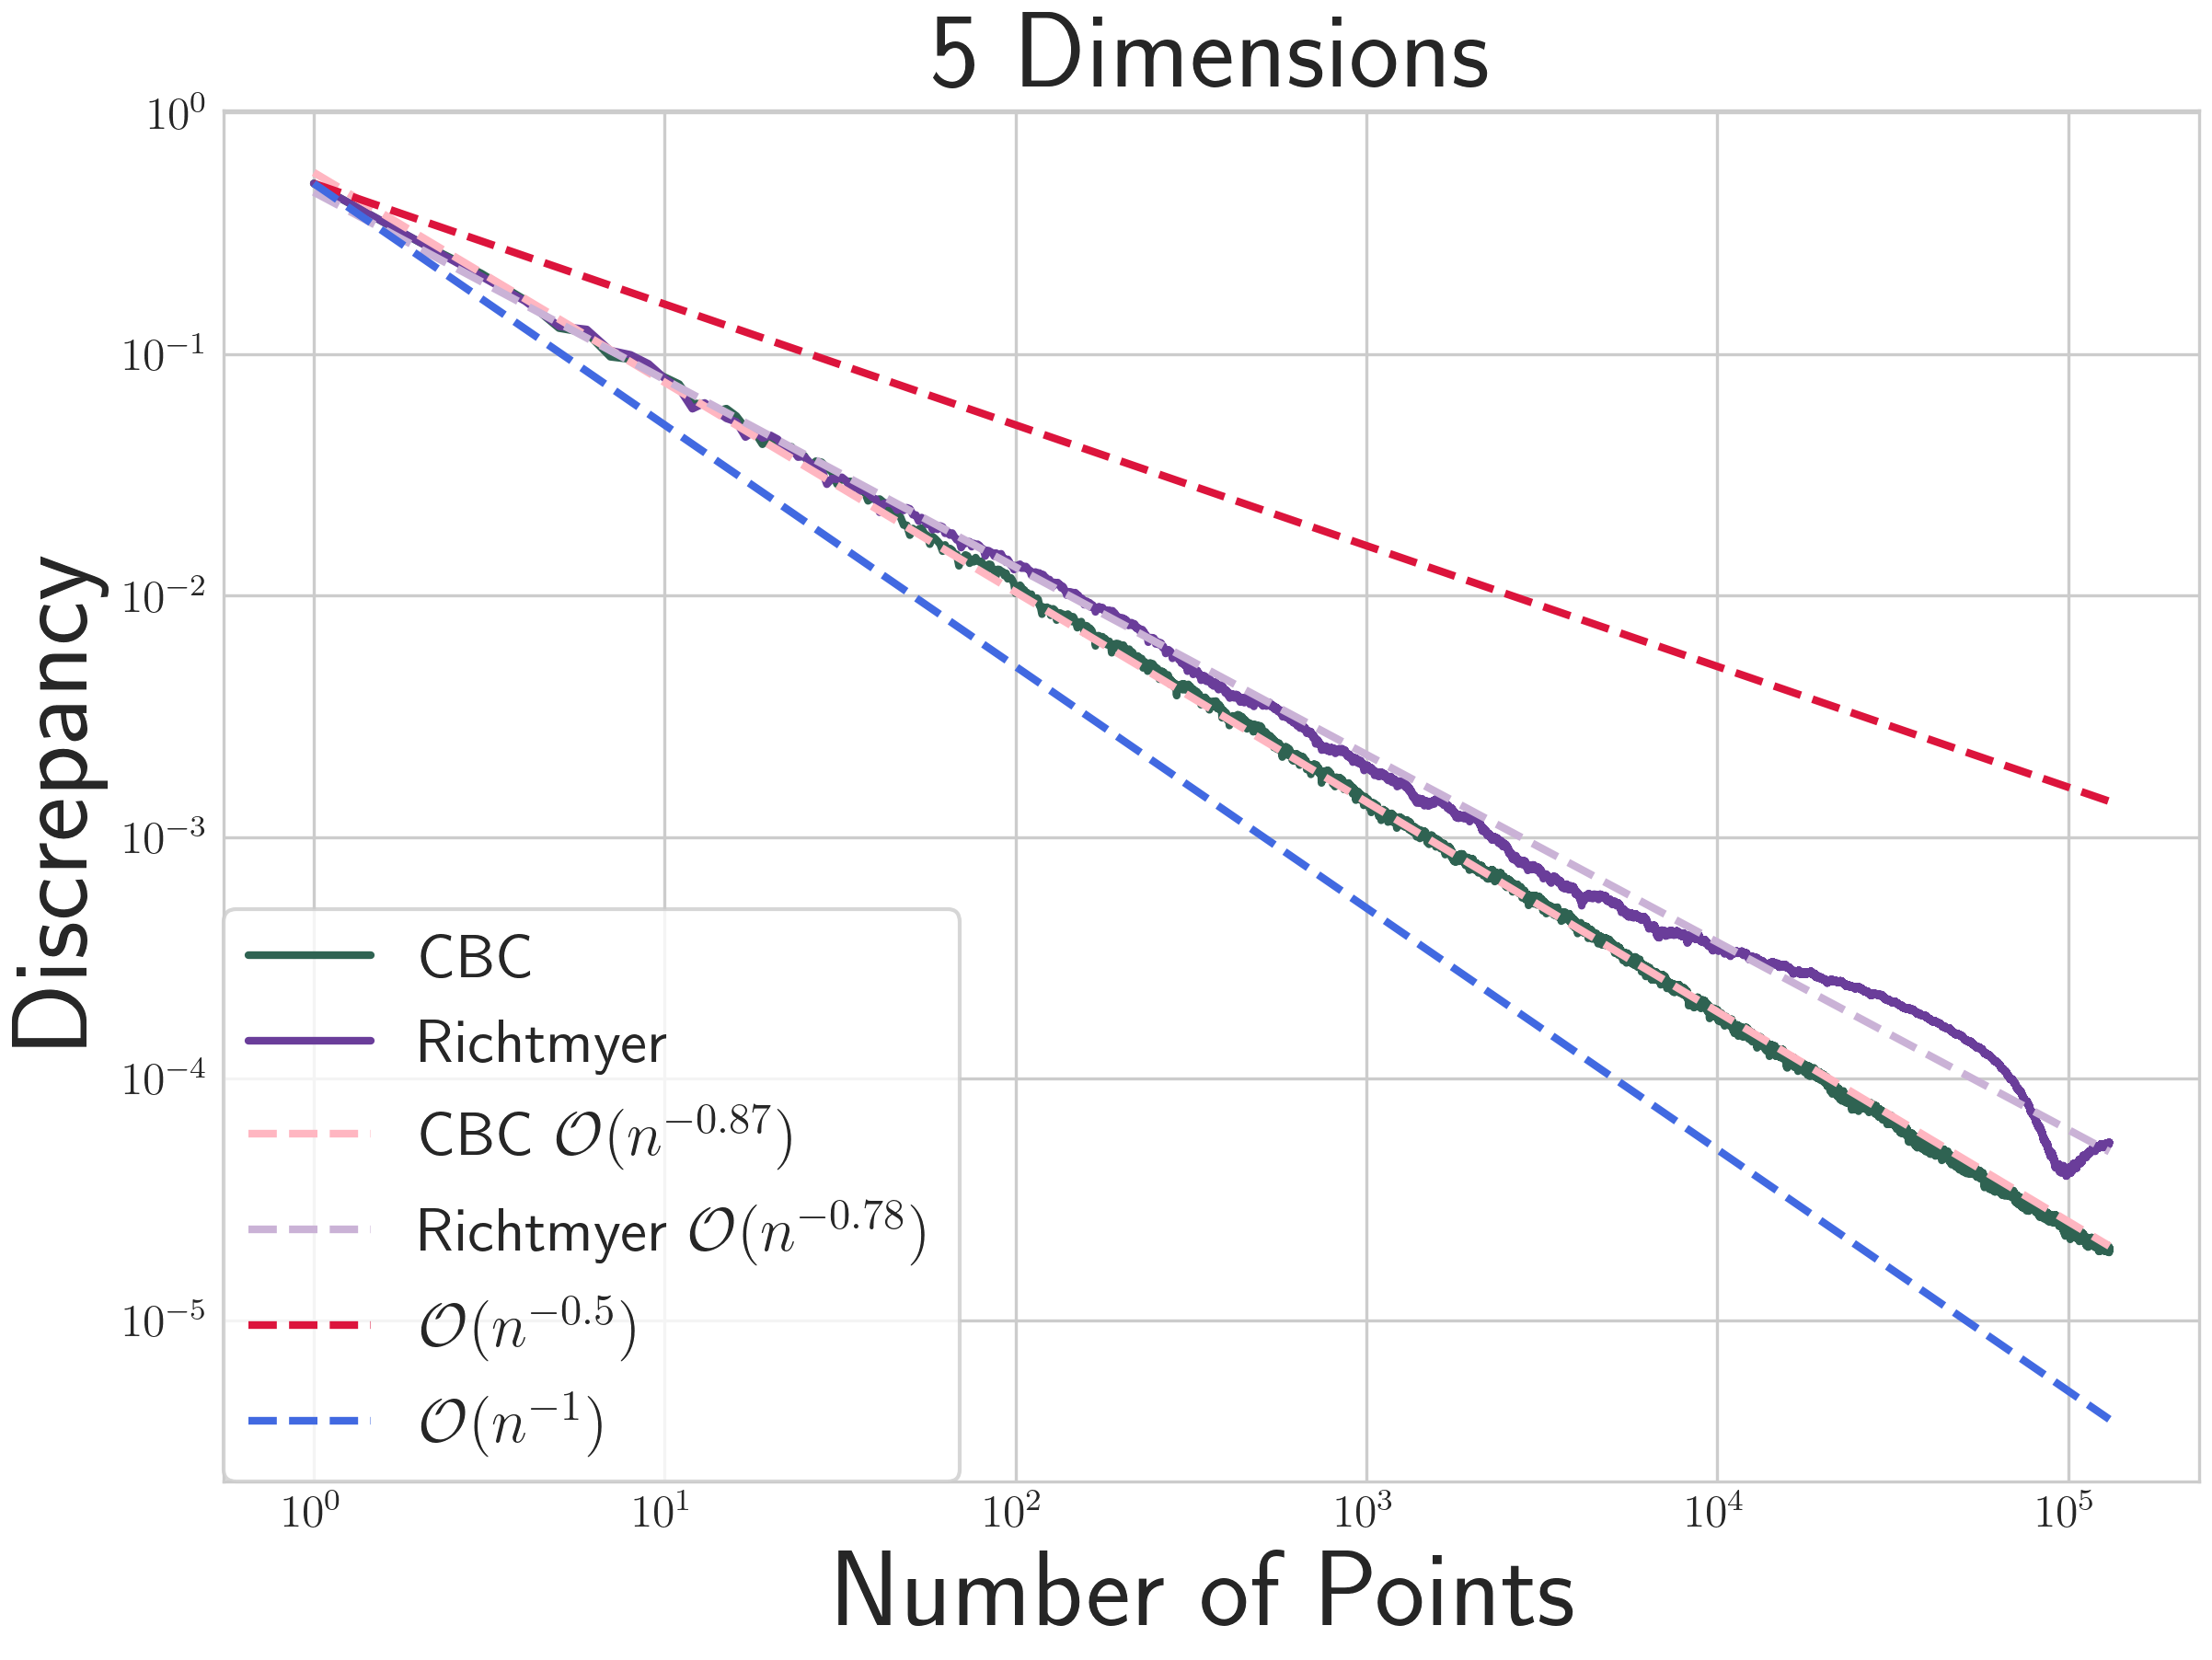

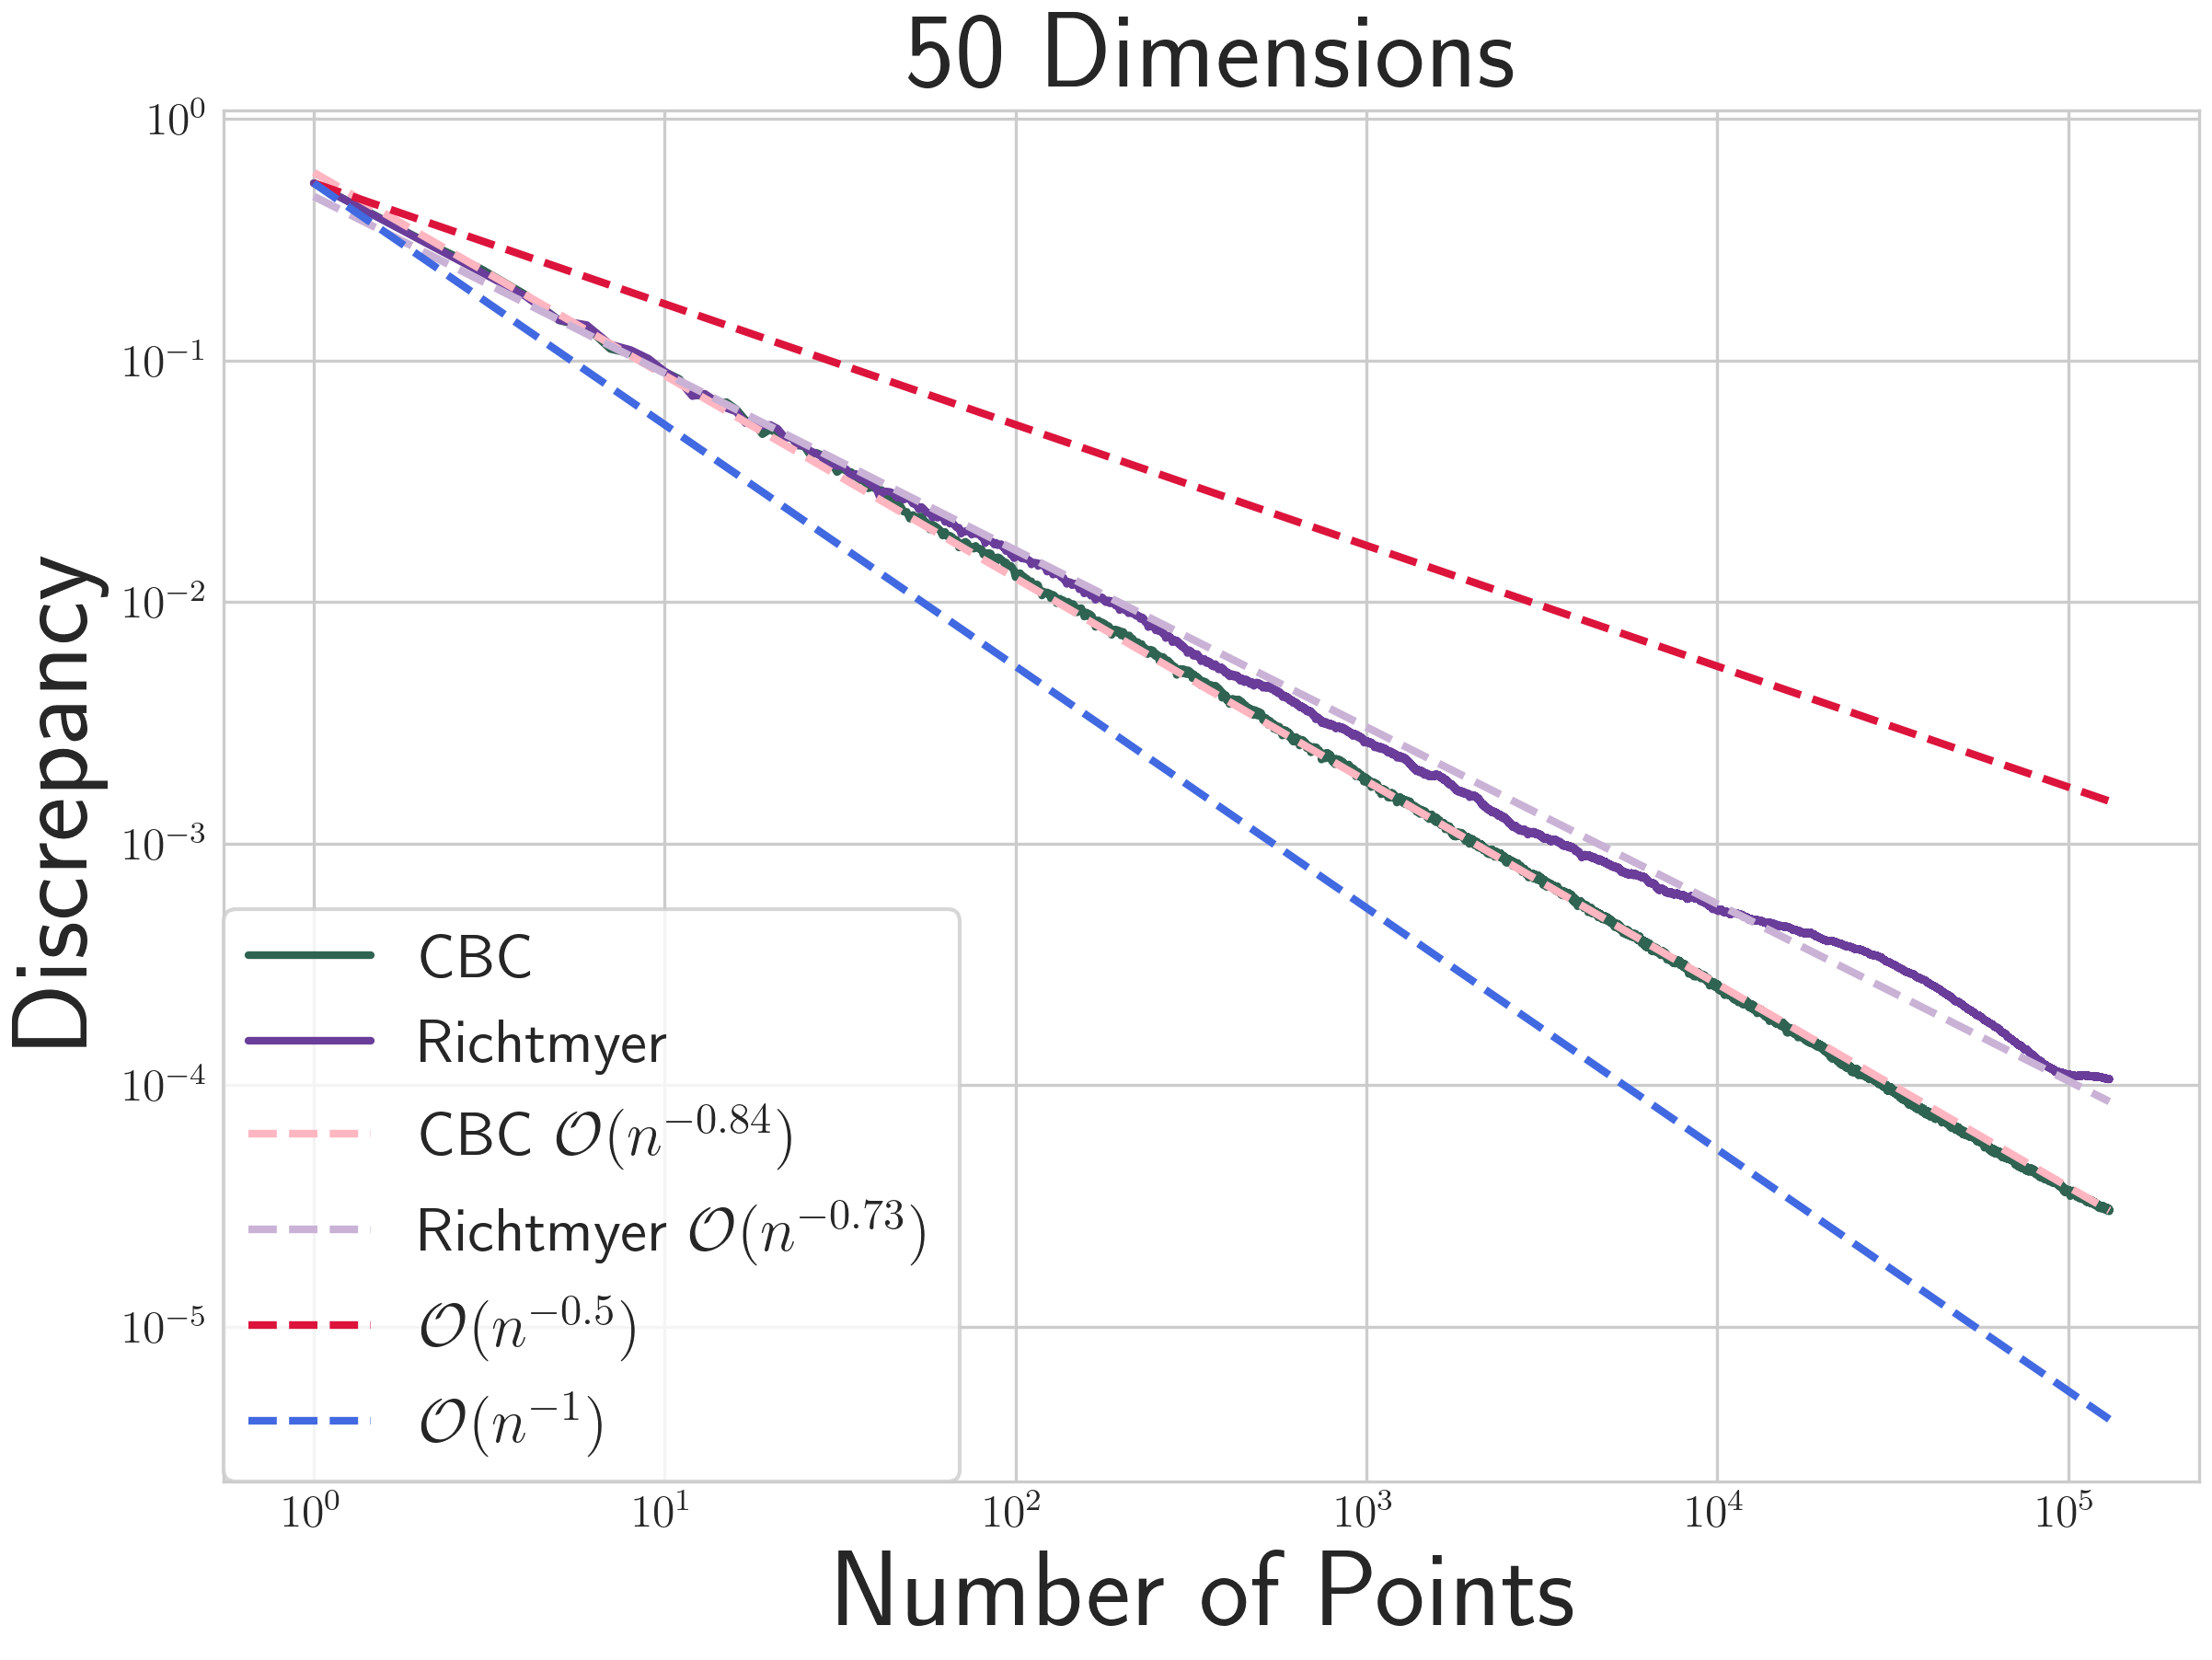

In [12]:
n = 2 ** 17
weight = 1 / np.sqrt(np.arange(1, n + 1))
x = np.arange(1, int(n) + 1)

cbc_color = '#2F6352'
cbc_trend_color = 'lightpink'

paired = plt.colormaps['Paired'].colors
richt_color = paired[9]
richt_trend_color = paired[8]

half_color = 'crimson'
one_color = 'royalblue'
for d, g in zip(dimensions, gammas):
    fig, ax = plt.subplots(layout = "constrained")

    richt_values = qp.Kronecker(dimension = d, alpha = 'richtmyer').periodic_discrepancy(n, gamma = g)
    cbc_values = qp.Kronecker(dimension = d, alpha = d50_alpha[:d]).periodic_discrepancy(n, gamma = g)
    
    ax.loglog(x, cbc_values, label = 'CBC', color = cbc_color)
    ax.loglog(x, richt_values, label = 'Richtmyer', color = richt_color)

    m, b = np.polyfit(np.log(x), np.log(cbc_values), 1, w = weight)
    ax.plot(x, np.e ** (m * np.log(x) + b), label=f'CBC $\\mathcal{{O}}(n^{{{m:.2f}}})$', linestyle = '--', linewidth = trend_width, color =cbc_trend_color)

    m, b = np.polyfit(np.log(x), np.log(richt_values), 1, w = weight)
    ax.plot(x, np.e ** (m * np.log(x) + b), label=f'Richtmyer $\\mathcal{{O}}(n^{{{m:.2f}}})$', linestyle = '--', linewidth = trend_width, color = richt_trend_color)

    # Trend Lines
    ax.loglog(x, cbc_values[0] / np.sqrt(x), label = '$\mathcal{{O}}(n^{-0.5})$', linestyle = '--', linewidth = trend_width, color = half_color)
    ax.loglog(x, cbc_values[0] / x, label = '$\mathcal{{O}}(n^{-1})$', linestyle = '--', linewidth = trend_width, color = one_color)

    ax.set_title(str(d) + ' Dimensions', fontsize = axes_size)
    ax.set_xlabel('Number of Points', fontsize = axes_size)
    ax.set_ylabel('Discrepancy', fontsize = axes_size)
    ax.legend(loc = 'lower left', frameon = True, fontsize = legend_size)

    save_figure('kronecker/compare_dim' + str(d), fig)

## CBC Experiment (Kronecker)

In [47]:
# First index is trial number.
# For each trial, the array contains 7 tuples, one for each n_alpha.
# For each tuple, the first element is a 20 length alpha array, the wssd, and the time it took to compute.

# results = np.load('../n_alpha_results/results.npy', allow_pickle = True)
results = np.load('../n_alpha_results/results_small_n.npy', allow_pickle = True)
n_alphas = np.array([2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 1e6], dtype = np.uint32)
fontsize = 26

In [48]:
# Find 1st quartile, median, and 3rd quartile of times and wssds
def find_experiment_statistics(results_array, num_alpha):
    times = np.empty(shape = (3, num_alpha))
    wssds = np.empty(shape = (3, num_alpha))
    quantiles = (0.25, 0.5, 0.75)

    for i in range(num_alpha):
        times_result = np.array([result[2] for result in results[:, i]])
        wssds_result = np.array([result[1] for result in results[:, i]])

        for index, quantile in enumerate(quantiles):
            times[index][i] = np.quantile(times_result, quantile)
            wssds[index][i] = np.quantile(wssds_result, quantile)

    return times, wssds

def plot_experiment(results, ylabel, ylog = True):
    q1_index = 0
    med_index = 1
    q3_index = 2

    fig, ax = plt.subplots(layout = "constrained")
    ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')

    ax.plot(n_alphas, results[med_index], linestyle = '-', marker = 'o', color = 'blue')
    ax.fill_between(n_alphas, results[q1_index], results[q3_index], alpha = 0.5, color = 'orange')

    ax.set_xlabel('$n_{\\alpha}$', fontsize = fontsize)
    ax.set_ylabel(ylabel, fontsize = fontsize)

    return fig, ax

In [49]:
times, wssd = find_experiment_statistics(results, len(n_alphas))

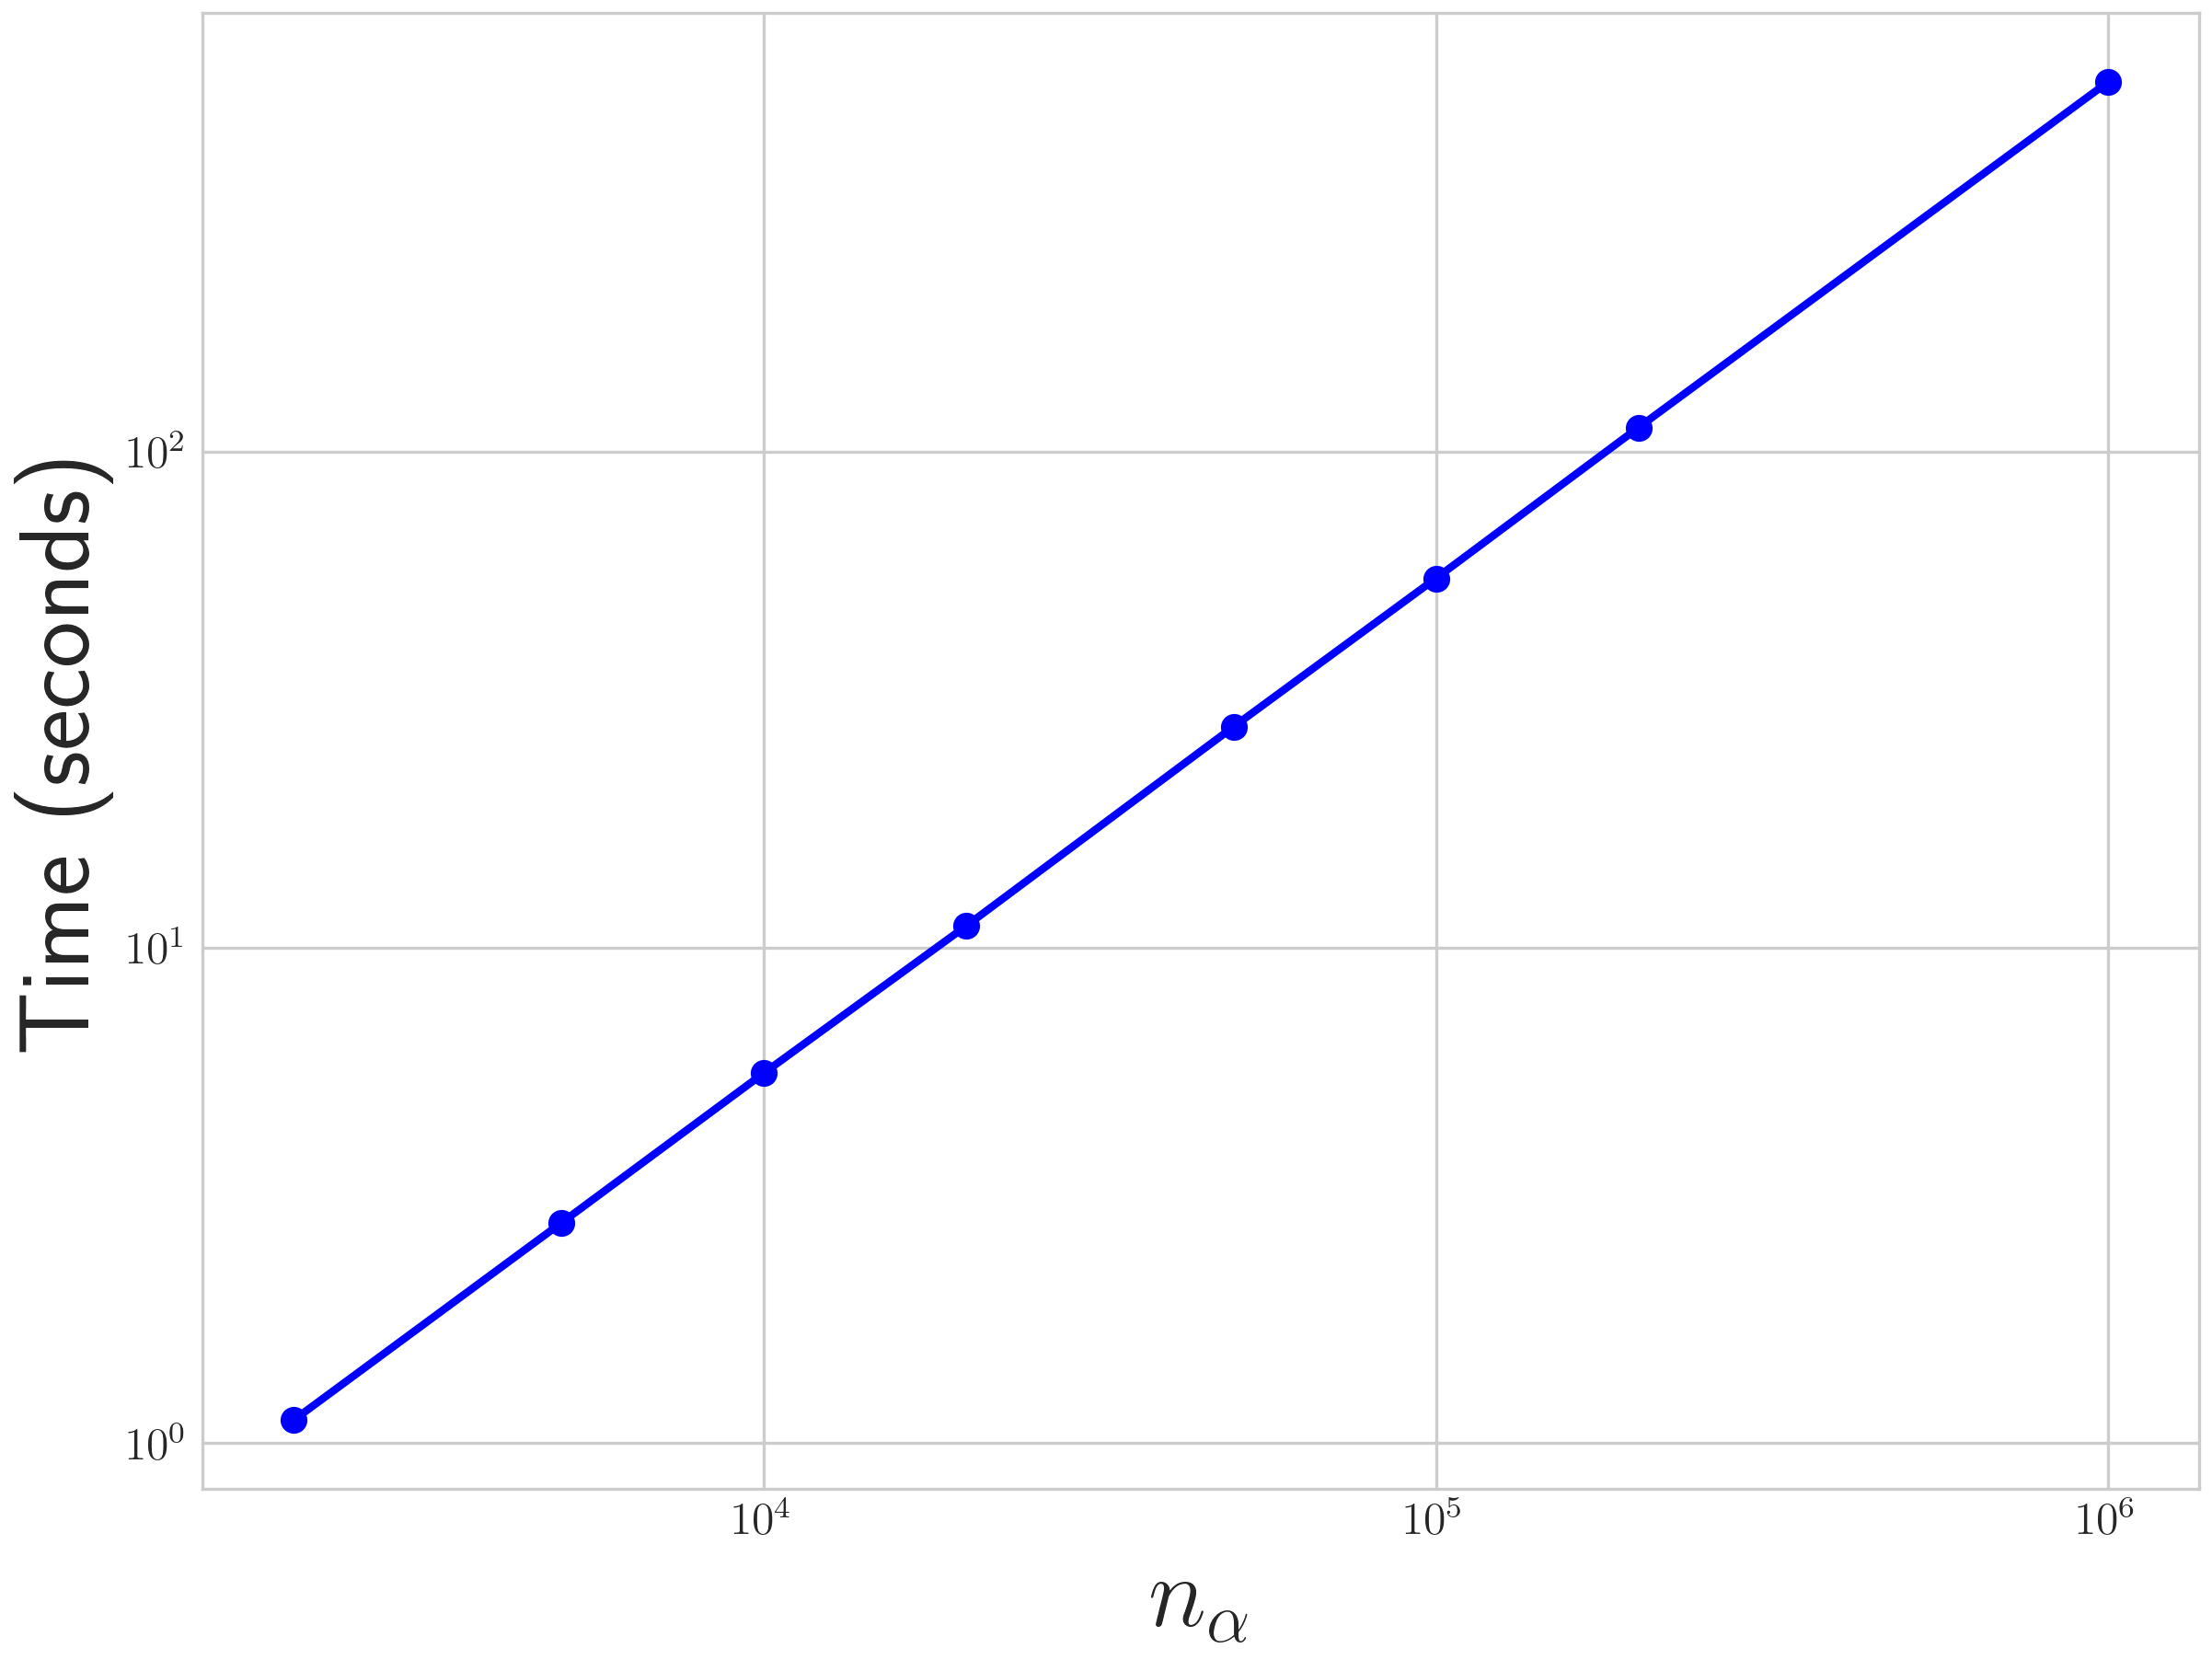

In [50]:
fig, ax = plot_experiment(times, 'Time (seconds)')
save_figure('time_result', fig)

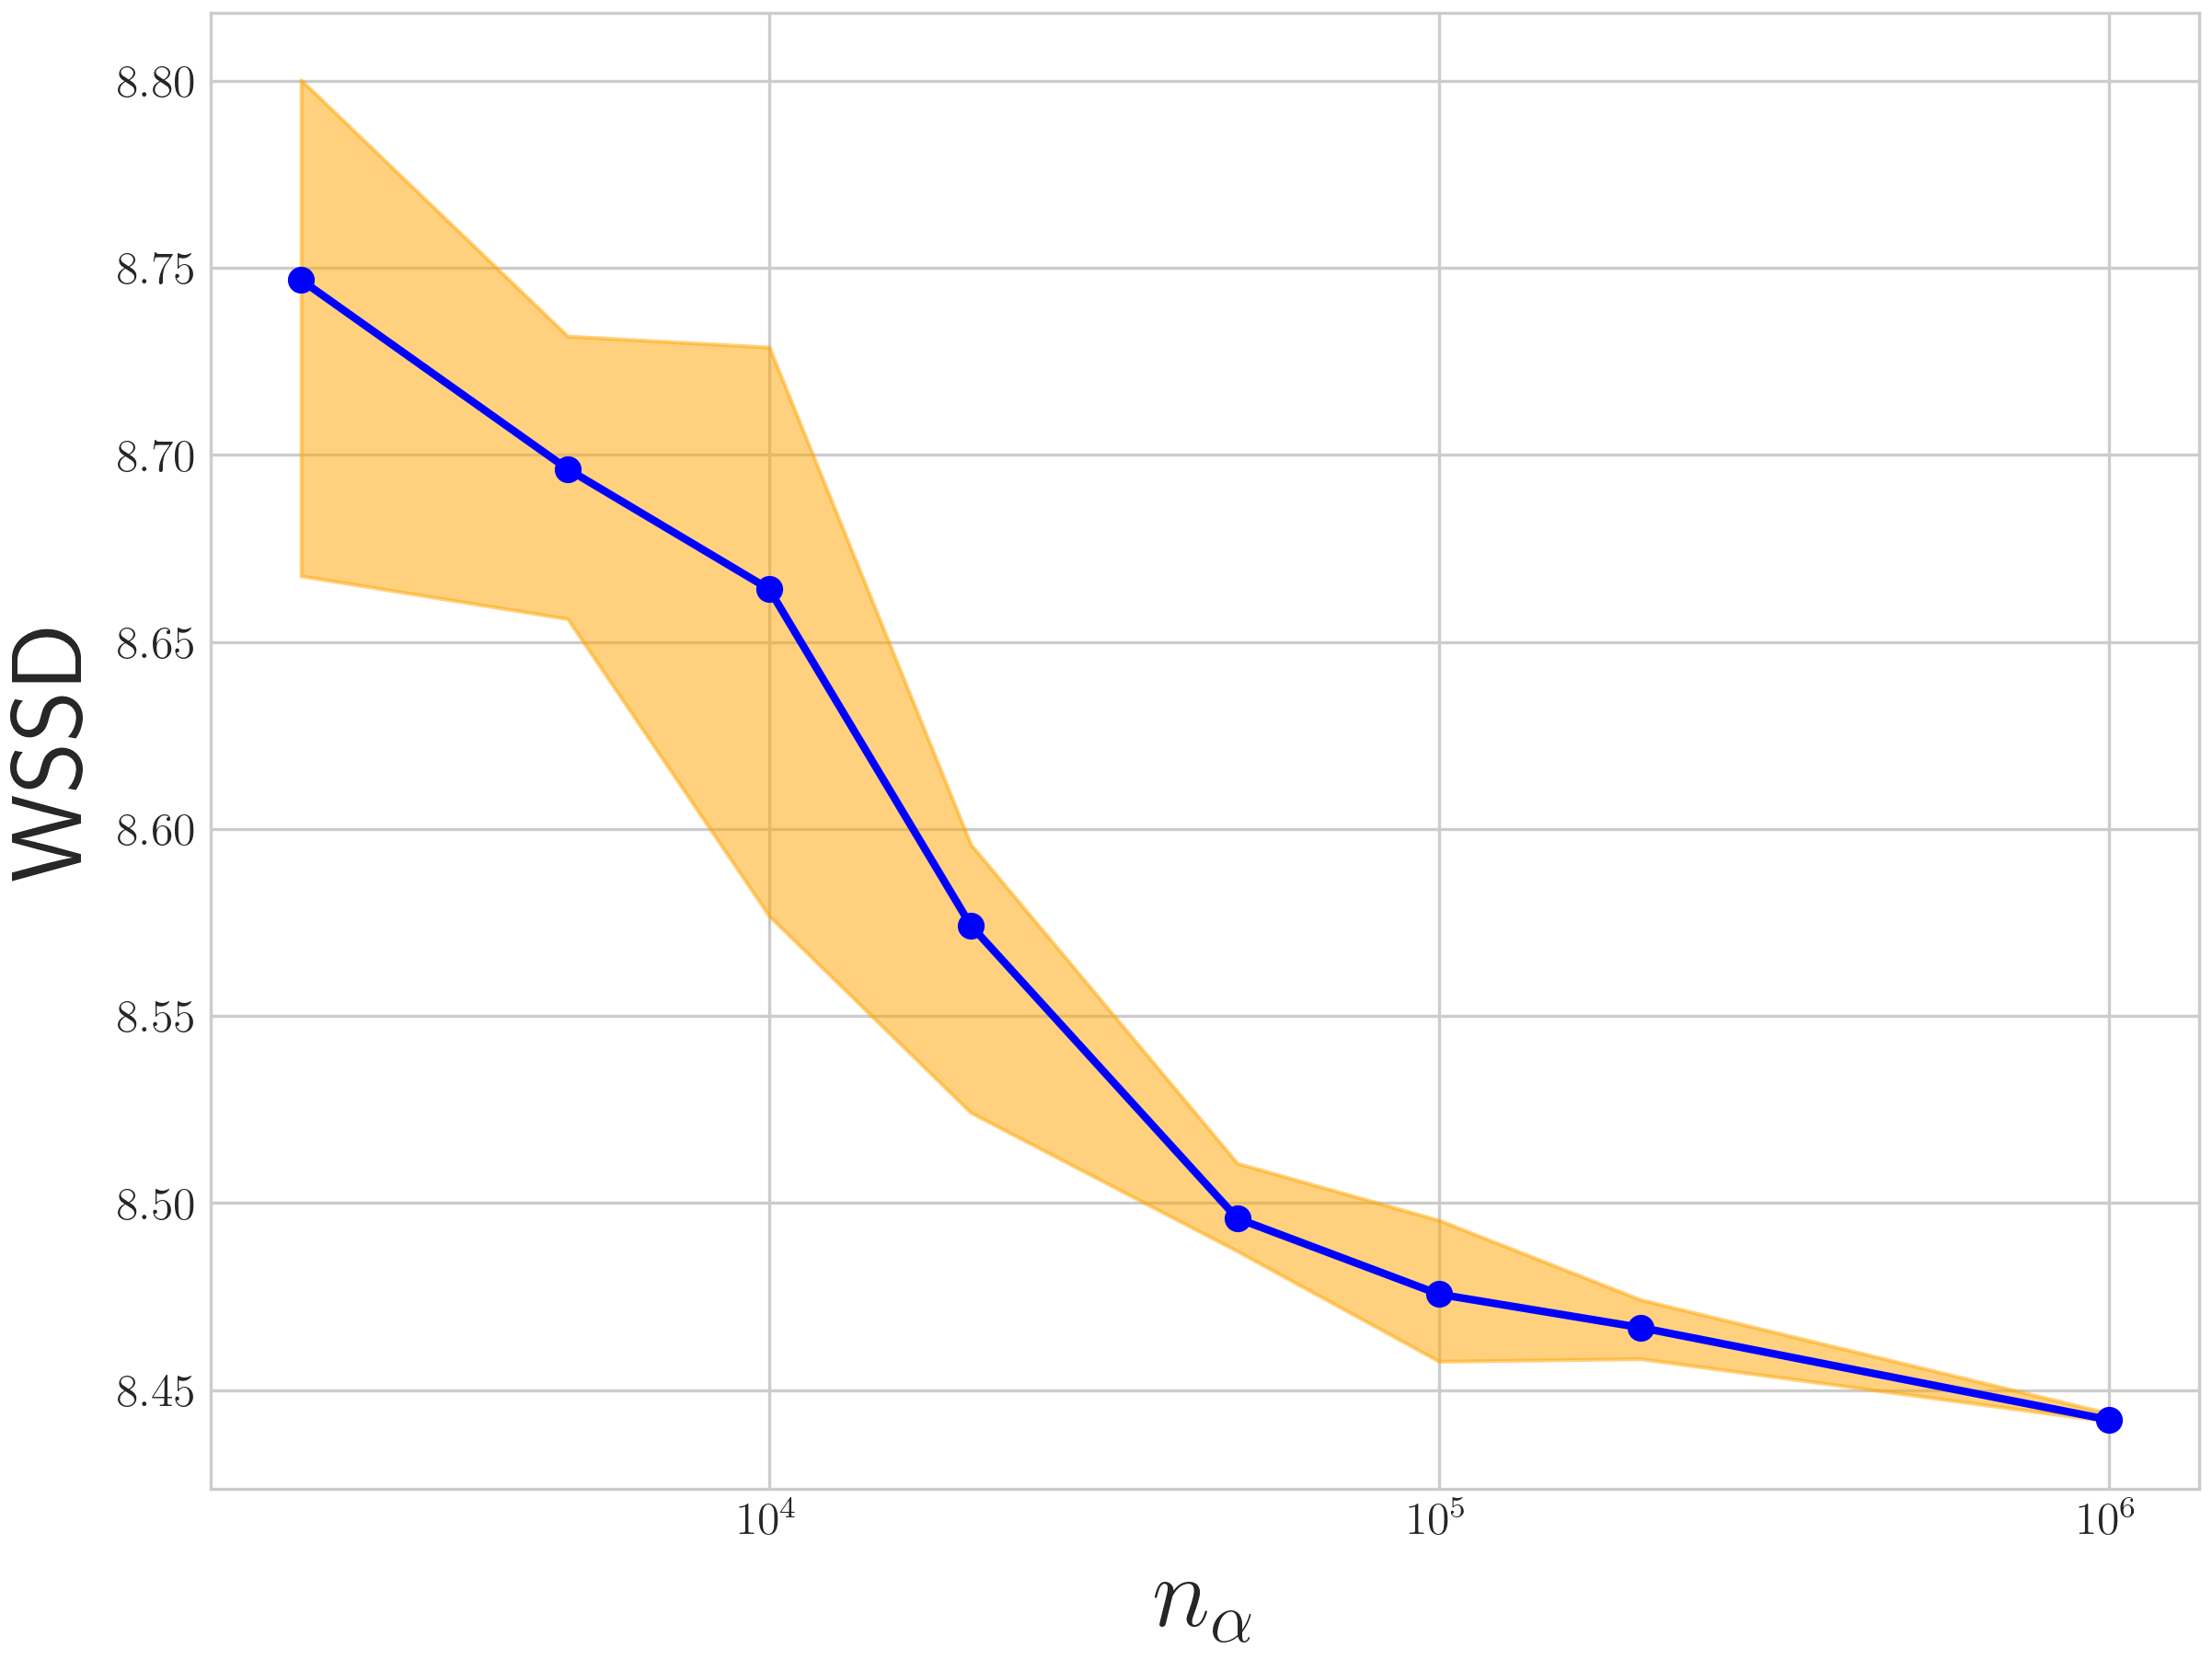

In [51]:
fig, ax = plot_experiment(wssd, 'WSSD', ylog = False)
save_figure('wssd_result', fig)

## Lattice: New CBC and Kuo et al.

We compare our CBC searched generating vector to the one found by Kuo et al.

In [18]:
new_dim5 = np.genfromtxt(Path('lattice_compare/2exp17_5dim_new_lattice_disc_data.csv'), delimiter = ',', dtype = np.float64)
kuo_dim5 = np.genfromtxt(Path('lattice_compare/2exp17_5dim_old_lattice_disc_data.csv'), delimiter = ',', dtype = np.float64)

new_dim50 = np.genfromtxt(Path('lattice_compare/2exp17_50dim_new_lattice_disc_data.csv'), delimiter = ',', dtype = np.float64)
kuo_dim50 = np.genfromtxt(Path('lattice_compare/2exp17_50dim_old_lattice_disc_data.csv'), delimiter = ',', dtype = np.float64)

dim5 = [new_dim5, kuo_dim5]
dim50 = [new_dim50, kuo_dim50]
lattice_disc = [dim5, dim50]

In [19]:
# Decay rates calculated for lattice separately for Kuo (since optimized for 2^10 to 2^20)
dim5_kuo_decay = -0.9032
dim5_kuo_intercept = -0.27

dim50_kuo_decay = -0.8597
dim50_kuo_intercept = -0.0952

kuo_lines = ((dim5_kuo_decay, dim5_kuo_intercept), (dim50_kuo_decay, dim50_kuo_intercept))

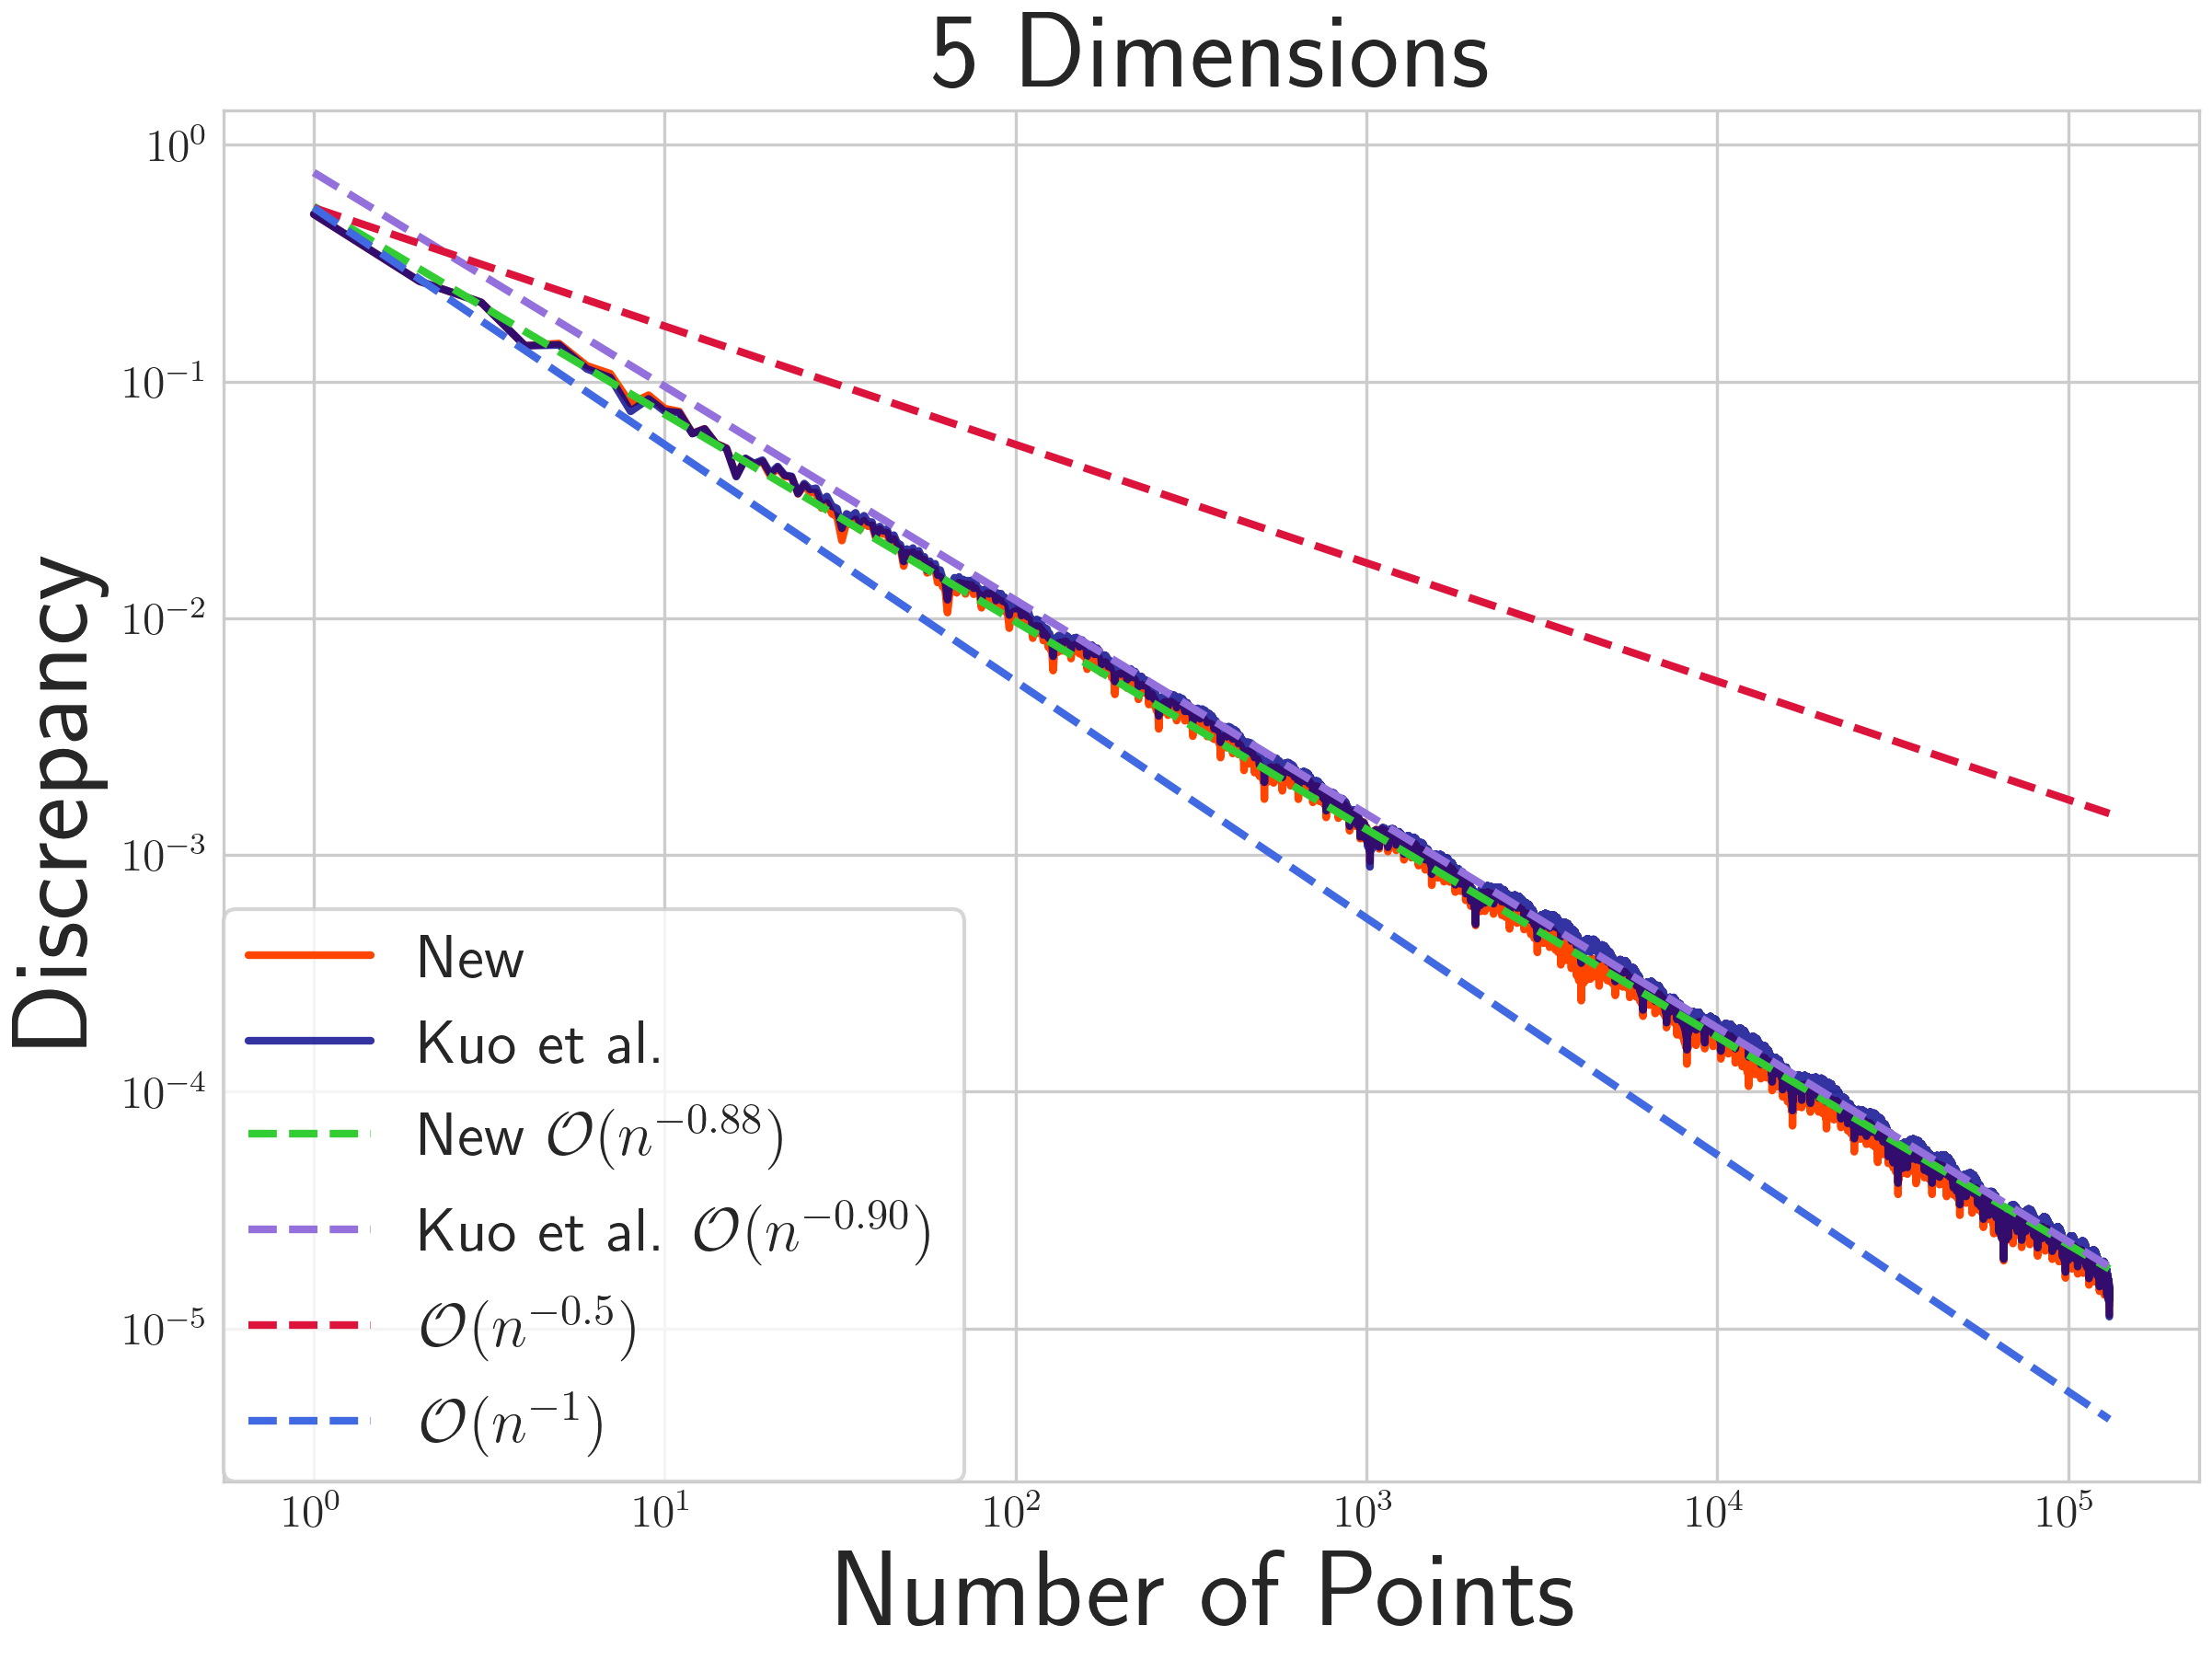

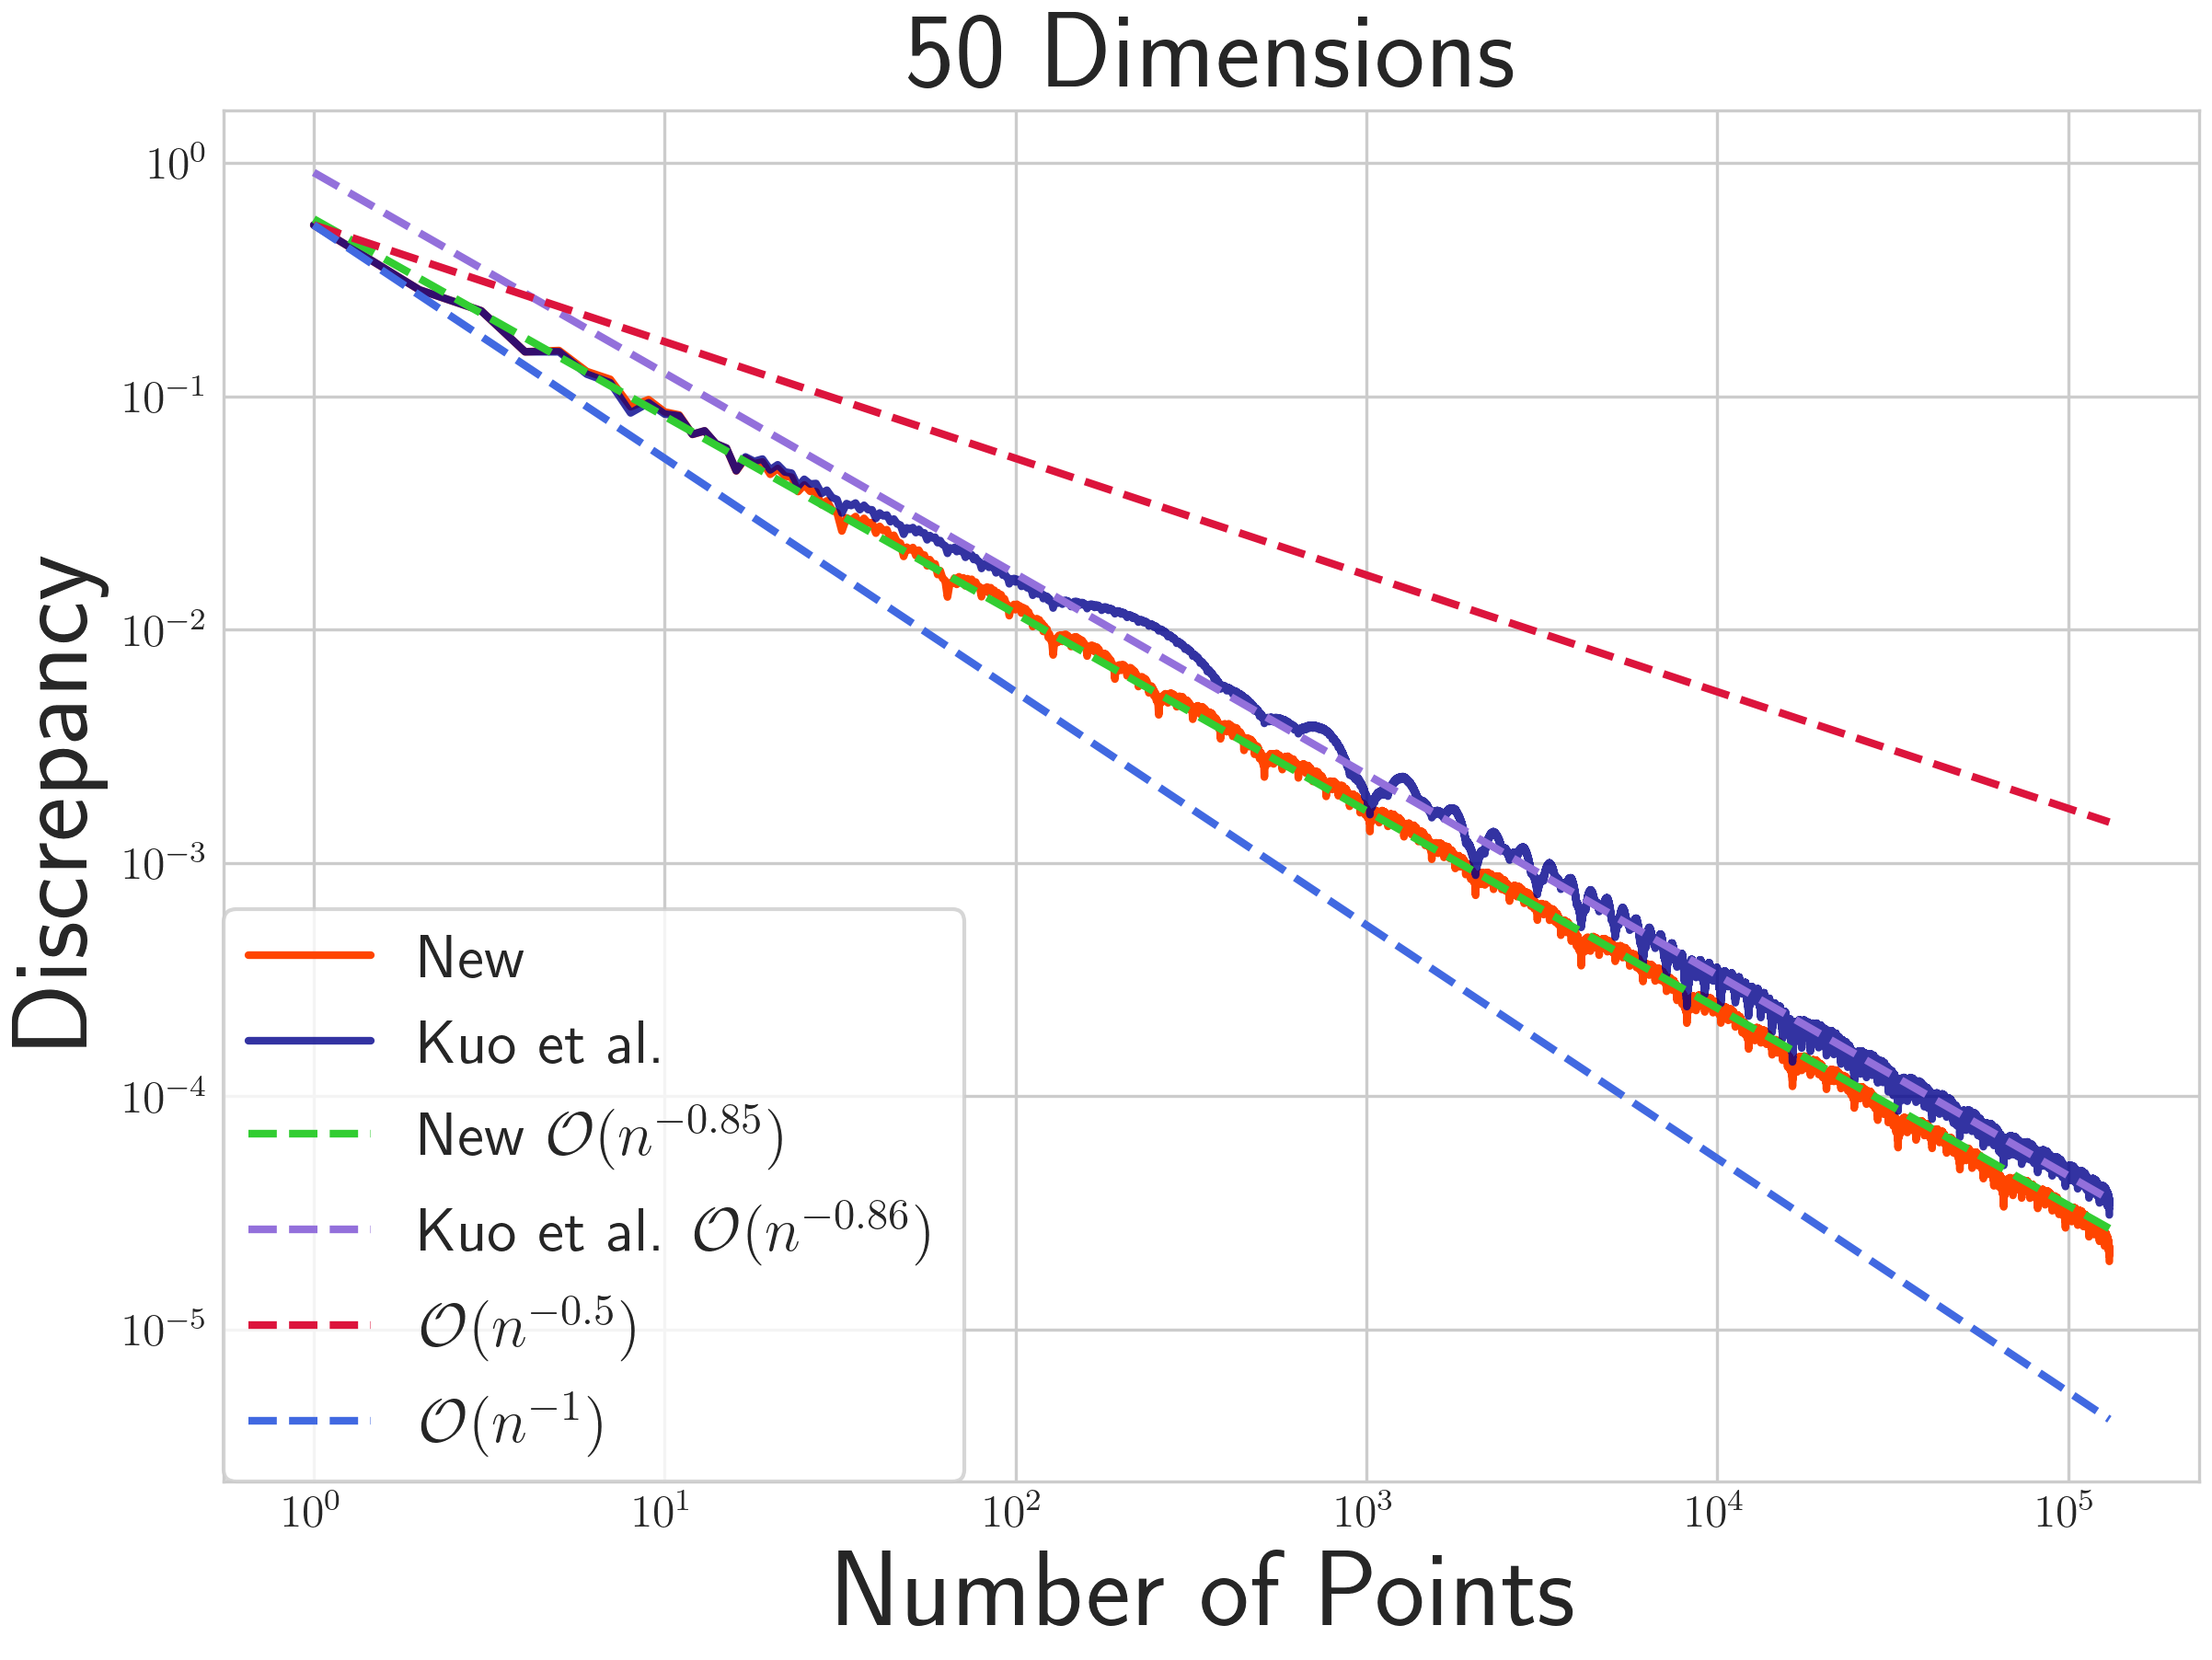

In [20]:
for i, d in enumerate(dimensions):
    fig, ax = plt.subplots(layout = "constrained")

    new_lat_color = 'orangered'
    new_lat_trend_color = 'limegreen'

    kuo_lat_color = 'darkblue'
    kuo_lat_trend_color = 'mediumpurple'

    # Discrepancies
    ax.loglog(x, lattice_disc[i][0], label = 'New', color = new_lat_color)
    ax.loglog(x, lattice_disc[i][1], label = 'Kuo et al.', color = kuo_lat_color, alpha = 0.8)

    
    m, b = np.polyfit(np.log(x), np.log(lattice_disc[i][0]), 1, w = weight)
    ax.plot(x, np.e ** (m * np.log(x) + b), label=f'New $\\mathcal{{O}}(n^{{{m:.2f}}})$', linestyle = '--', linewidth = trend_width, color = new_lat_trend_color)

    ax.plot(x, np.e ** (kuo_lines[i][0] * np.log(x) + kuo_lines[i][1]), label=f'Kuo et al. $\\mathcal{{O}}(n^{{{kuo_lines[i][0]:.2f}}})$',
            linestyle = '--', linewidth = trend_width, color = kuo_lat_trend_color)

    # Trend Lines
    ax.loglog(x, cbc_values[0] / np.sqrt(x), label = '$\mathcal{{O}}(n^{-0.5})$', linestyle = '--', linewidth = trend_width, color = half_color)
    ax.loglog(x, cbc_values[0] / x, label = '$\mathcal{{O}}(n^{-1})$', linestyle = '--', linewidth = trend_width, color = one_color)

    ax.set_title(str(d) + ' Dimensions', fontsize = axes_size)
    ax.set_xlabel('Number of Points', fontsize = axes_size)
    ax.set_ylabel('Discrepancy', fontsize = axes_size)
    ax.legend(loc = 'lower left', frameon = True, fontsize = legend_size)

    save_figure('lattice/compare_dim' + str(d), fig)

# Decay Comparisons

We calculate the convergence rate of discrepancy per dimension using a weighted linear regression for both Kronecker and Lattice sequences.

In [21]:
def square_discrepancy(k_tilde_terms, n_array, n):
    left_sum = np.cumsum(k_tilde_terms[1:]) * n_array[1:]
    right_sum = np.cumsum(n_array[:-1] * k_tilde_terms[1:])

    k_tilde_zero_terms = k_tilde_terms[0] * n_array
    summation = np.zeros(n)
    summation[1:] = left_sum - right_sum
    return (k_tilde_zero_terms + 2 * summation) / (n_array ** 2) - 1

# calculates the decay rate for dimensions 2, ..., d
def calculate_decay(dimension, alpha, gamma, n, x, weight):
    decays = np.empty(dimension)

    n = int(n)
    n_array = np.arange(1, n + 1)

    kronecker = qp.Kronecker(dimension = dimension, alpha = alpha)
    samples = kronecker.gen_samples(n)

    previous_k_tilde = 1
    for d in range(1, dimension + 1):
        k_tilde = (1 + (samples[:, d - 1] * (samples[:, d - 1] - 1) + 1/6) * gamma[d - 1]) * previous_k_tilde
        previous_k_tilde = k_tilde

        discrepancies = np.sqrt(square_discrepancy(k_tilde, n_array, n))
        decays[d - 1] = np.polyfit(np.log(x), np.log(discrepancies), 1, w = weight)[0]

    return decays[1:]

In [22]:
dimension = 1000

gamma = calculate_gamma(dimension) # creates a d-length np.array with values 1/l^2
dimensions = range(2, dimension + 1)

n = 2 ** 17
x = np.arange(1, int(n) + 1)

In [23]:
# Generating Vectors
d1000_alpha = np.loadtxt(Path('kron_vector/d1000_n1e5_1e4alpha.txt'))
new_decay = np.genfromtxt(Path('lat_decay_rates/2exp17_1000dim_new_lattice_decay_rate.csv'), delimiter=',', dtype=float)
kuo_decay = np.genfromtxt(Path('lat_decay_rates/2exp17_1000dim_old_lattice_decay_rate.csv'), delimiter=',', dtype=float)

In [24]:
# Decay Calculations
# weight = 1 / np.sqrt(np.arange(1, int(n) + 1))
richtmyer_rates = calculate_decay(dimension, 'richtmyer', gamma, n, x, weight)
cbc_rates = calculate_decay(dimension, d1000_alpha, gamma, n, x, weight)

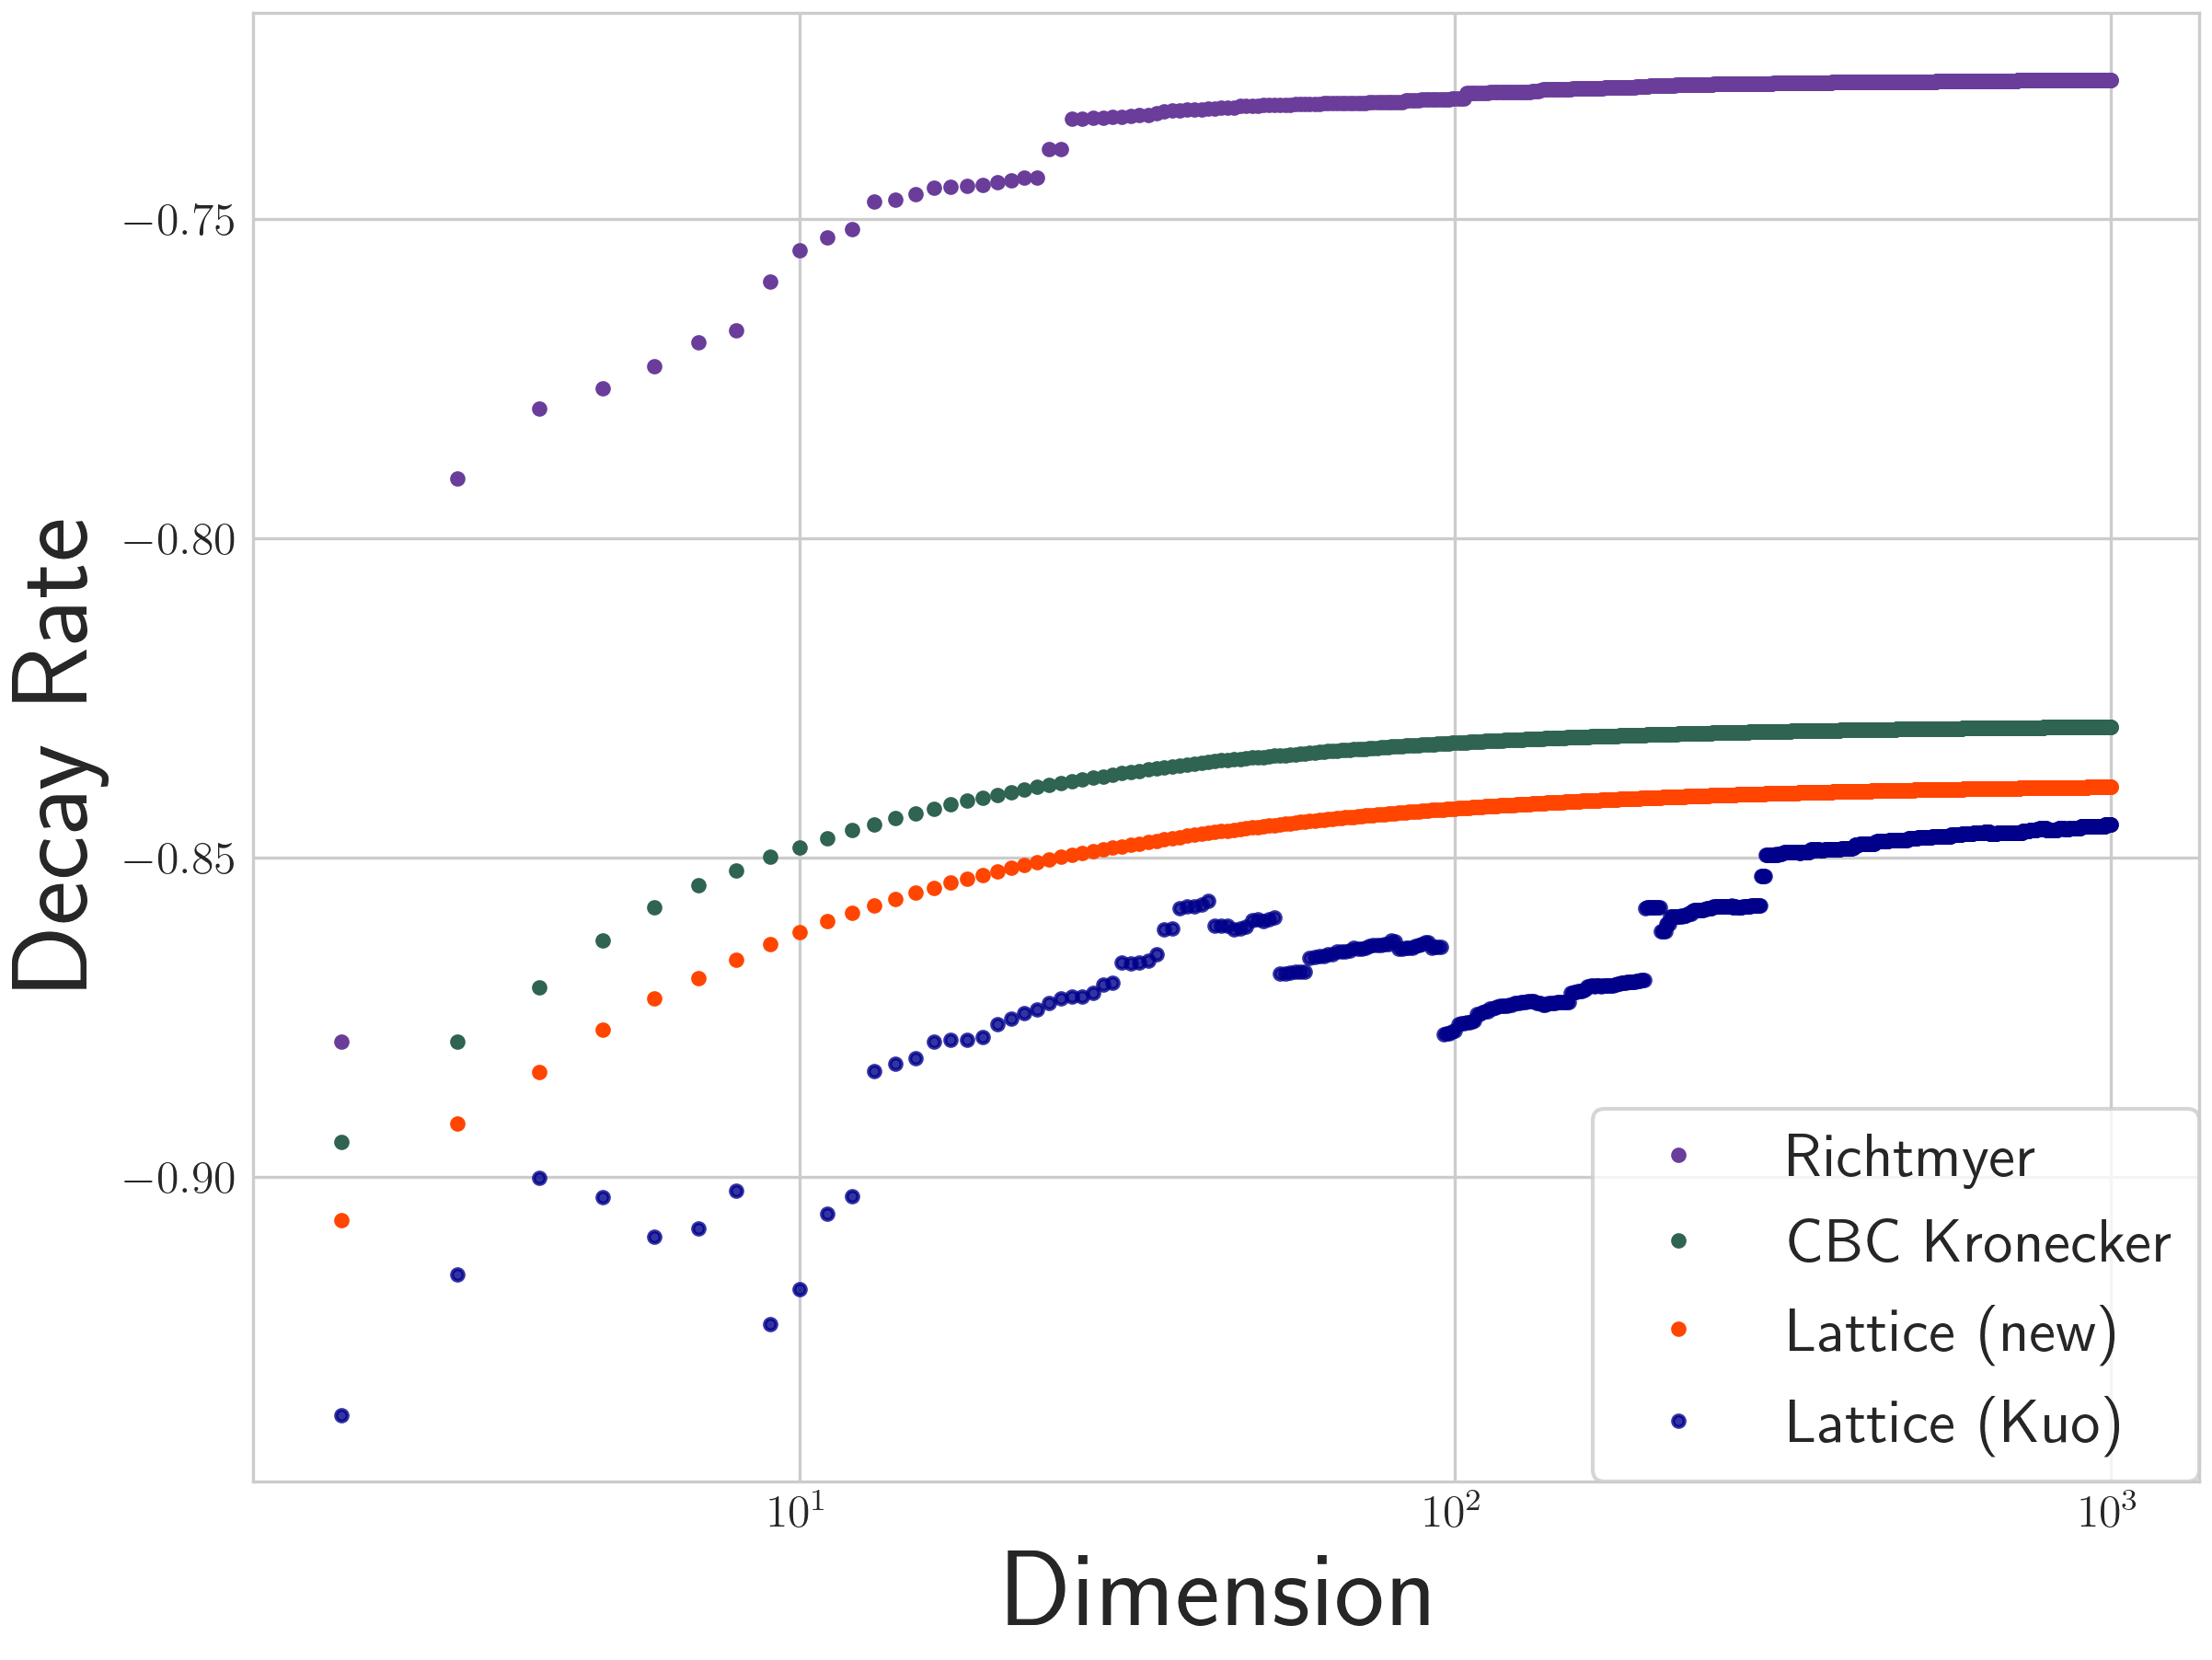

In [25]:
sequences = ['Richtmyer', 'CBC Kronecker', 'Lattice (new)', 'Lattice (Kuo)']
rates = [richtmyer_rates, cbc_rates, new_decay, kuo_decay]
fig, ax = plt.subplots(layout = "constrained")
colors = ((richt_color, 1), (cbc_color, 1), (new_lat_color, 1), (kuo_lat_color, 0.8))
ax.grid(True)
for i, name in enumerate(sequences):
    ax.semilogx(dimensions, rates[i], '.', label = name, color = colors[i][0], alpha = colors[i][1])

ax.set_xlabel('Dimension', fontsize = axes_size)
ax.set_ylabel('Decay Rate', fontsize = axes_size)
ax.legend(loc = 'lower right', frameon = True, fontsize = legend_size)
save_figure('both/decay', fig)

# Stopping Criterion (using CLT)
With good generating vectors, we can test their performance against other LD sequences for various integrands. We compare Kronecker, L
Lattice, Halton, and IID MC sequences when using CubQMCCLT. We will use the Keister function and Asian Option as examples.

In [26]:
time_index = 0
n_index = 1

fontsize = 26
legend_size = 20

q1_index = 0
med_index = 1
q3_index = 2

colors = {'Kronecker': cbc_color, 'Halton': 'firebrick', 'Lattice (new)': new_lat_color, 'Lattice (Kuo et al.)': kuo_lat_color, 'IID': 'darkorchid'}
def plot_graph(results, iid_results, ylabel, legend_size):
    seqs = ['Kronecker', 'Halton', 'Lattice (new)', 'Lattice (Kuo et al.)']
    fig, ax = plt.subplots(layout = "constrained")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.invert_xaxis()

    i = len(seqs)
    ax.plot(tolerances[:iid_len], iid_results[med_index], label = 'IID', linestyle = '-', marker = '.', color = colors['IID'])
    ax.fill_between(tolerances[:iid_len], iid_results[q1_index], iid_results[q3_index], color = colors['IID'], linestyle = '-', alpha = 0.4)

    for i, seq in enumerate(seqs):
        ax.plot(tolerances, results[med_index][i], label = seq, color = colors[seq], linestyle = '-', marker = '.')
        ax.fill_between(tolerances, results[q1_index][i], results[q3_index][i], color = colors[seq], linestyle = '-', alpha = 0.4)

    ax.set_xlabel('Absolute Tolerance', fontsize = fontsize)
    ax.set_ylabel(ylabel, fontsize = fontsize)
    ax.legend(loc='upper left', fontsize = legend_size, frameon = True)

    return fig, ax

# Find 1st quartile, median, and 3rd quartile of times and medians
def find_statistics(results_array, num_sequences, num_tolerances):
    times = np.empty(shape = (3, num_sequences, num_tolerances))
    samples = np.empty(shape = (3, num_sequences, num_tolerances))
    quantiles = (0.25, 0.5, 0.75)

    for i in range(num_sequences):
        for j in range(num_tolerances):
            times_result = results_array[:, time_index, i, j]
            samples_result = results_array[:, n_index, i, j]
            for index, quantile in enumerate(quantiles):
                times[index][i][j] = np.quantile(times_result, quantile)
                samples[index][i][j] = np.quantile(samples_result, quantile)

    return times, samples

# Find 1st quartile, median, and 3rd quartile of times and medians (IID version)
def find_iid_statistics(iid_results_arr, num_tolerances):
    iid_times = np.empty(shape = (3, num_tolerances))
    iid_samples = np.empty(shape = (3, num_tolerances))
    quantiles = (0.25, 0.5, 0.75)

    for i in range(num_tolerances):
        times_result = iid_results_arr[:, time_index, i]
        samples_result = iid_results_arr[:, n_index, i]
        for index, quantile in enumerate(quantiles):
            iid_times[index][i] = np.quantile(times_result, quantile)
            iid_samples[index][i] = np.quantile(samples_result, quantile)

    return iid_times, iid_samples

In [27]:
alpha = np.loadtxt(Path('kron_vector/d13_n1e6_2e4alpha.txt'))

## Keister Function

In [28]:
dimension = 3
tolerances = np.array([0.5, 0.3053, 0.1, 0.0695, 0.0158, 0.0097, 0.0059, 0.0022, 0.0013, 0.0008, 0.0005, 0.00025, 0.0001, 0.00005, 0.000025])
trials = 30

sequences = [qp.Kronecker(dimension = dimension, alpha = alpha[:dimension], randomize = True),
             qp.Halton(dimension = dimension),
             qp.Lattice(dimension = dimension, generating_vector = '2exp20_9125dim_new_lattice_rule.txt'),
             qp.Lattice(dimension = dimension)]

In [29]:
# results = np.empty((trials, 2, len(sequences), len(tolerances)))
# for trial in tqdm(range(trials)):
#     for i, tolerance in enumerate(tolerances):
#         for j, sequence in enumerate(sequences):
#             data = qp.CubQMCCLT(qp.Keister(sequence), abs_tol = tolerance).integrate()[1]
#             results[trial][time_index][j][i] = data.time_integrate
#             results[trial][n_index][j][i] = data.n_total

In [30]:
# np.save('keister_results', results)

IID points are MC, not QMC, so we use `CubMCCLT` instead.

In [31]:
iid_len = len(tolerances) - 5
# iid = qp.IIDStdUniform(dimension = dimension)
# iid_results = np.empty((trials, 2, len(tolerances[:iid_len])))

# for trial in tqdm(range(trials)):
#     for i, tolerance in enumerate(tolerances[:iid_len]):
#         data = qp.CubMCCLT(qp.Keister(iid), abs_tol = tolerance).integrate()[1]
#         iid_results[trial][time_index][i] = data.time_integrate
#         iid_results[trial][n_index][i] = data.n_total

# np.save('keister_iid_results', iid_results)

In [32]:
# print(iid_results.shape)

In [33]:
# times, samples = find_statistics(results, len(sequences), len(tolerances))
# iid_times, iid_samples = find_iid_statistics(iid_results, iid_len)

In [34]:
# fig = plot_graph(times, iid_times, 'Time')[0]
# save_figure('keister/times', fig)

In [35]:
# fig = plot_graph(samples, iid_samples, 'Number of Points')[0]
# save_figure('keister/samples', fig)

In [36]:
results = np.load('keister_results.npy', allow_pickle = True)
iid_results = np.load('keister_iid_results.npy', allow_pickle = True)

times, samples = find_statistics(results, len(sequences), len(tolerances))
iid_times, iid_samples = find_iid_statistics(iid_results, iid_len)

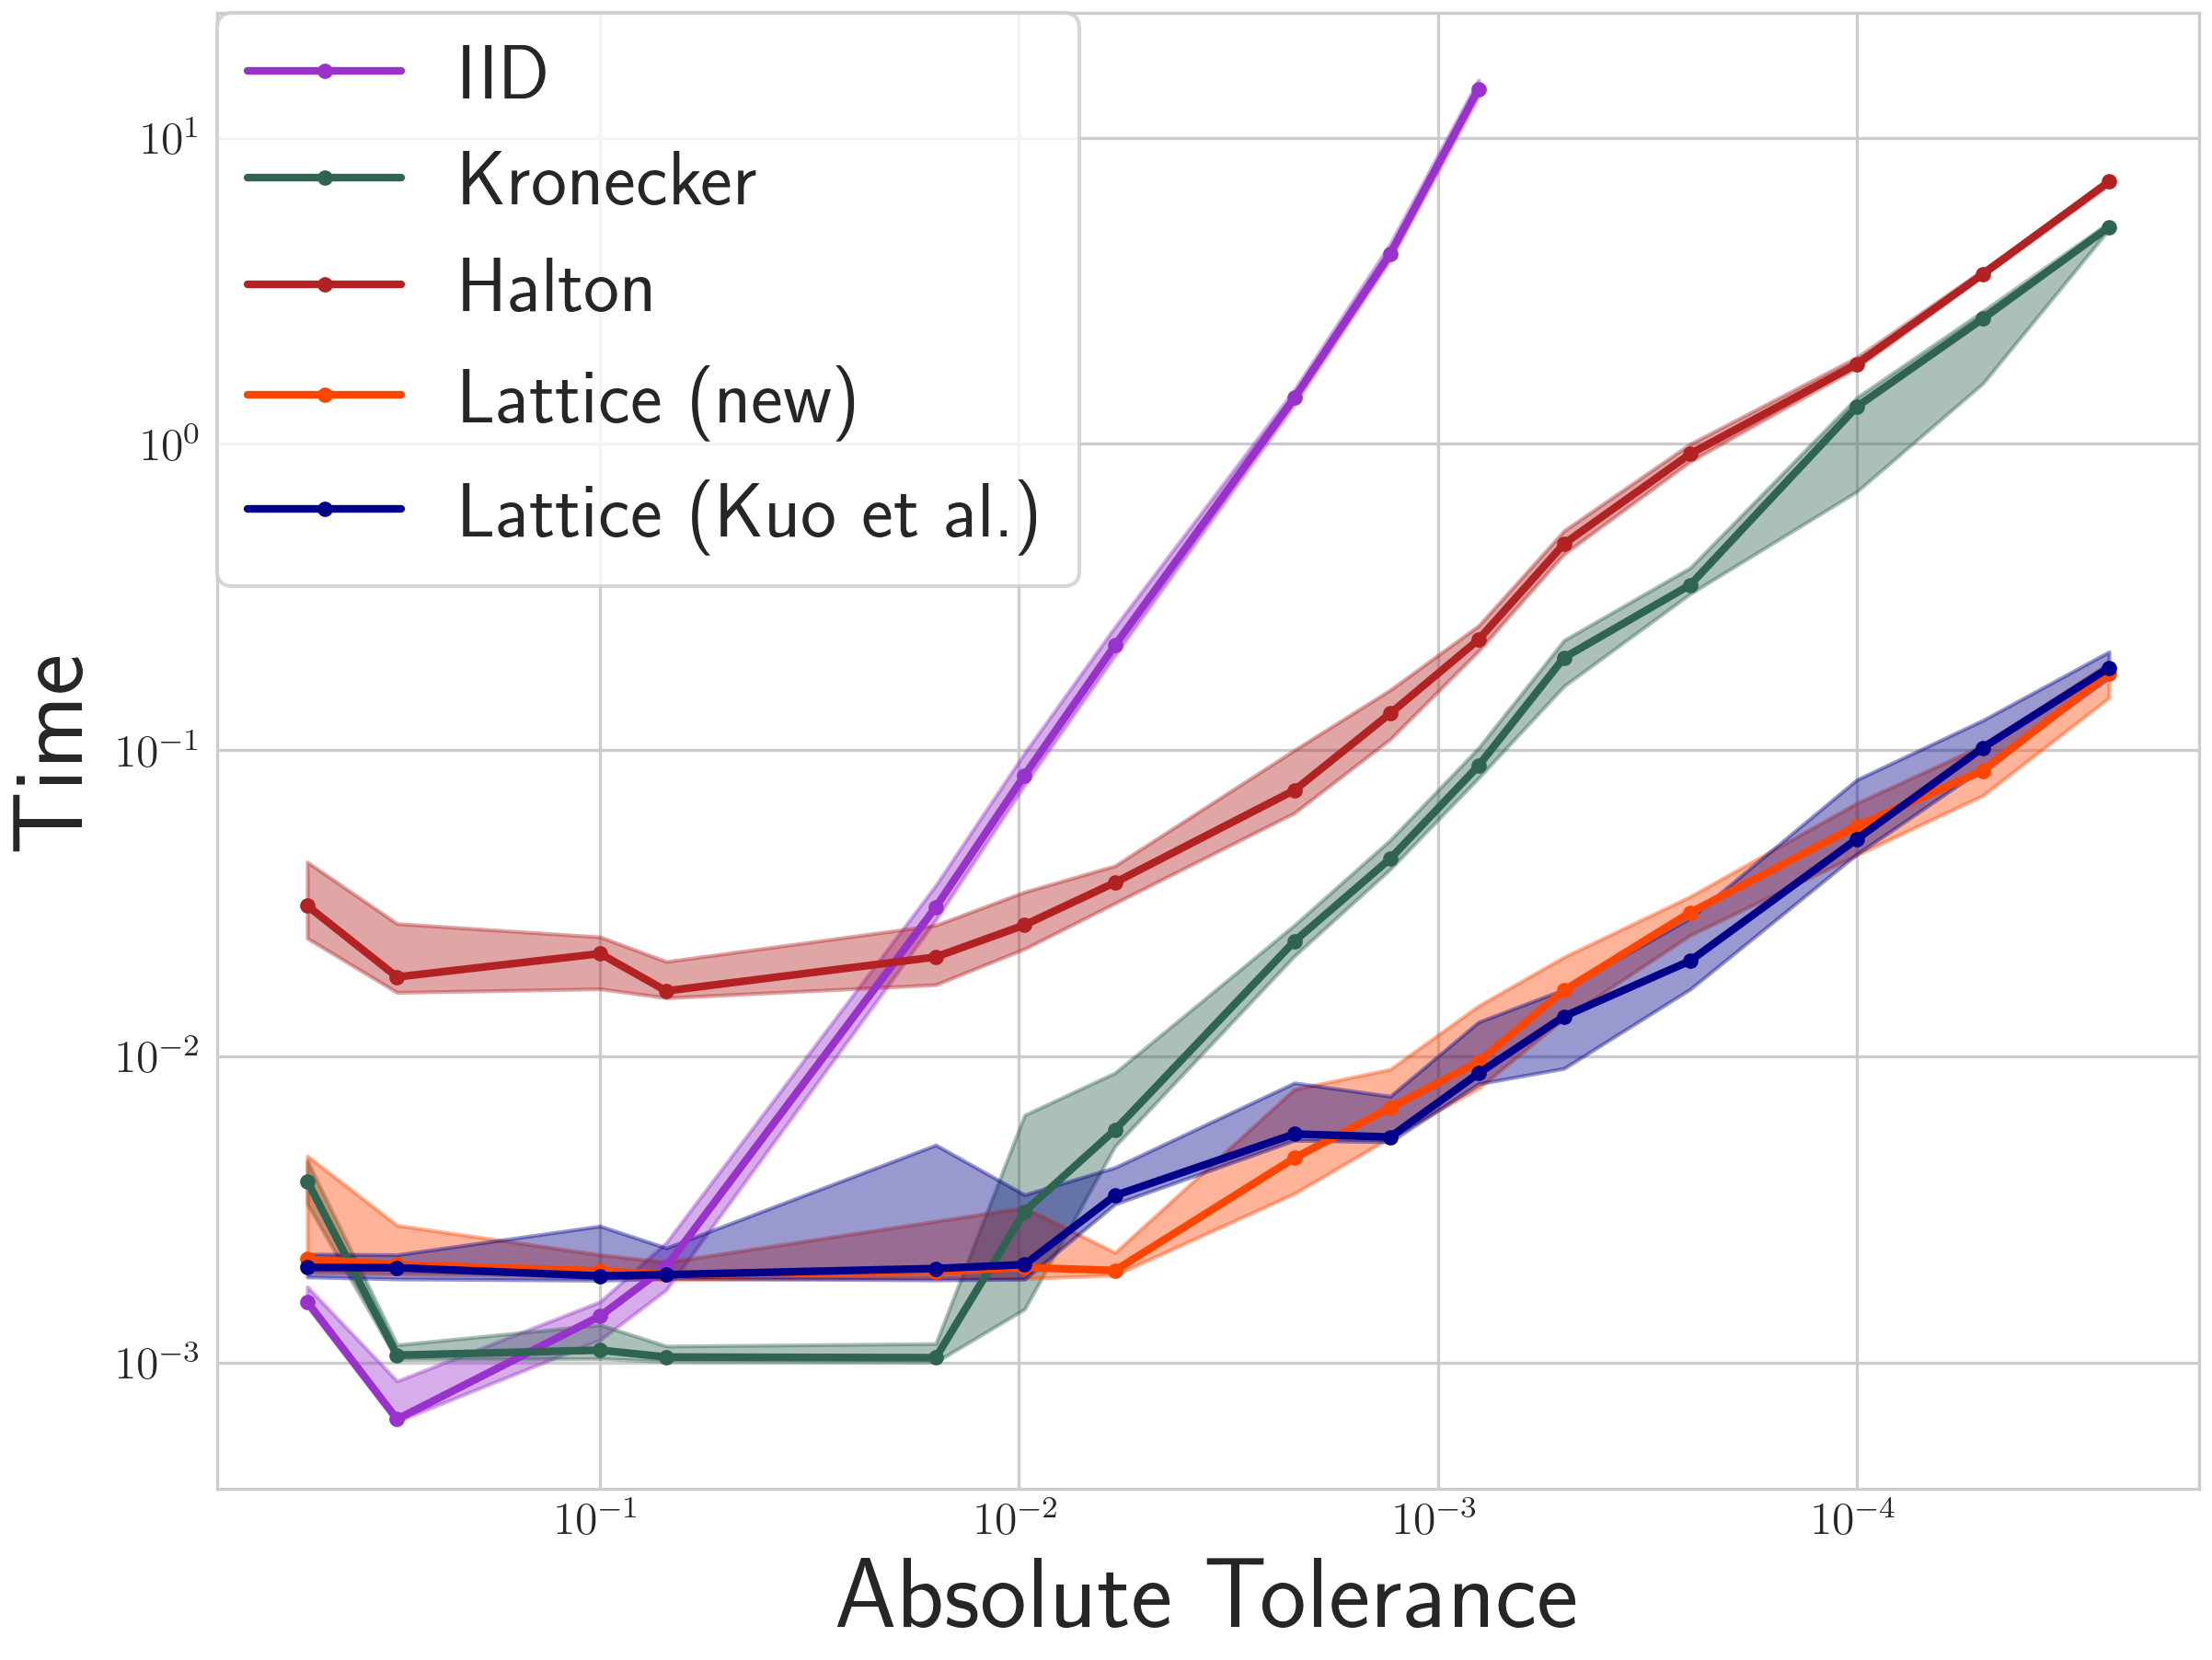

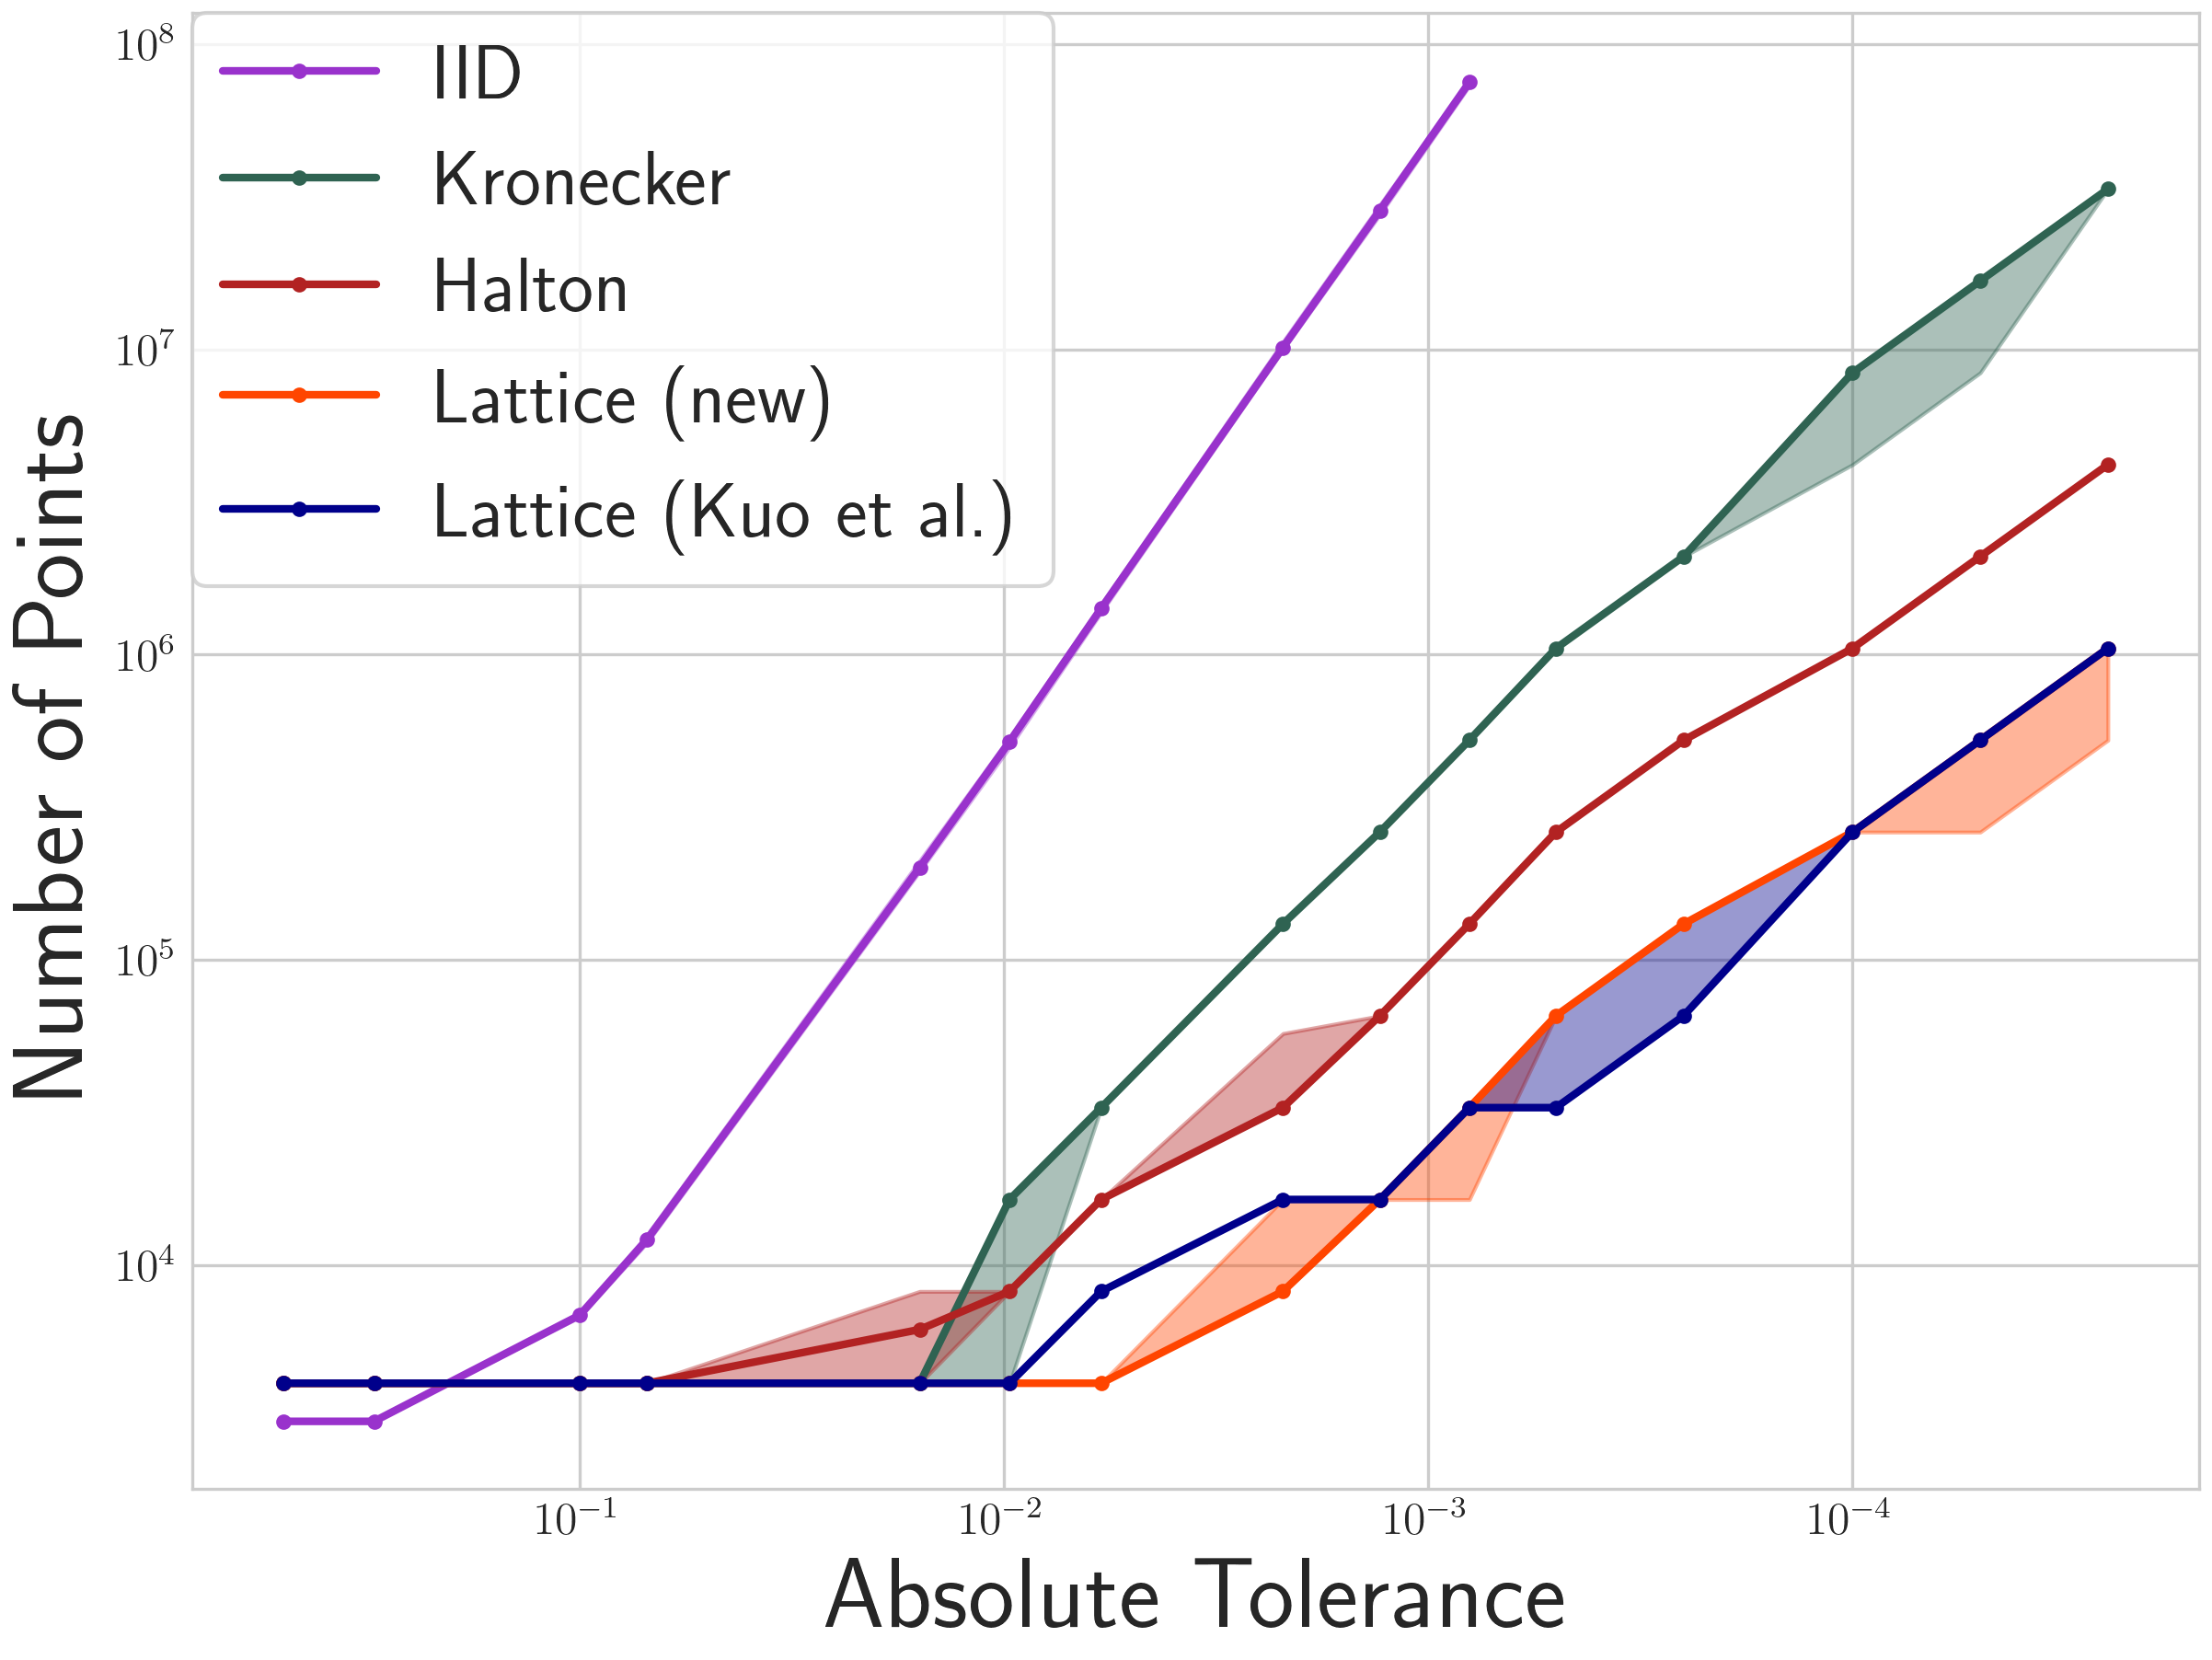

In [37]:
fig = plot_graph(times, iid_times, 'Time', legend_size)[0]
save_figure('keister/times', fig)

fig = plot_graph(samples, iid_samples, 'Number of Points', legend_size)[0]
save_figure('keister/samples', fig)

# Asian Option

In [38]:
dimension = 13
tolerances = np.array([0.5, 0.3053, 0.1864, 0.1138, 0.1, 0.0695, 0.0424, 0.0259, 0.0158, 0.0097, 0.0059, 0.0036, 0.0022, 0.0013, 0.0008])
trials = 20

sequences = [qp.Kronecker(dimension = dimension, alpha = alpha[:dimension], randomize = True),
             qp.Halton(dimension = dimension),
             qp.Lattice(dimension = dimension, generating_vector = '2exp20_9125dim_new_lattice_rule.txt'),
             qp.Lattice(dimension = dimension)]

results = np.empty((trials, 2, len(sequences), len(tolerances)))

In [39]:
# for trial in tqdm(range(trials)):
#     for i, tolerance in enumerate(tolerances):
#         for j, sequence in enumerate(sequences):
#             data = qp.CubQMCCLT(qp.AsianOption(sampler = sequence,
#                                                volatility = 0.50,
#                                                start_price = 120,
#                                                strike_price = 130,
#                                                interest_rate = 0.02,
#                                                t_final = 1,
#                                                call_put = 'call',
#                                                mean_type = 'arithmetic'), abs_tol = tolerance).integrate()[1]
#             results[trial][time_index][j][i] = data.time_integrate
#             results[trial][n_index][j][i] = data.n_total

# np.save('asian_option_results', results)

In [40]:
iid_len = 7
# iid = qp.IIDStdUniform(dimension = dimension)
# iid_results = np.empty((trials, 2, len(tolerances[:iid_len])))

# for trial in tqdm(range(trials)):
#     for i, tolerance in enumerate(tolerances[:iid_len]):
#         data = qp.CubMCCLT(qp.AsianOption(sampler = iid,
#                                                volatility = 0.50,
#                                                start_price = 120,
#                                                strike_price = 130,
#                                                interest_rate = 0.02,
#                                                t_final = 1,
#                                                call_put = 'call',
#                                                mean_type = 'arithmetic'), abs_tol = tolerance).integrate()[1]
#         iid_results[trial][time_index][i] = data.time_integrate
#         iid_results[trial][n_index][i] = data.n_total

# np.save('asian_option_iid_results', iid_results)

In [41]:
results = np.load('asian_option_results.npy', allow_pickle = True)
iid_results = np.load('asian_option_iid_results.npy', allow_pickle = True)

times, samples = find_statistics(results, len(sequences), len(tolerances))
iid_times, iid_samples = find_iid_statistics(iid_results, iid_len)

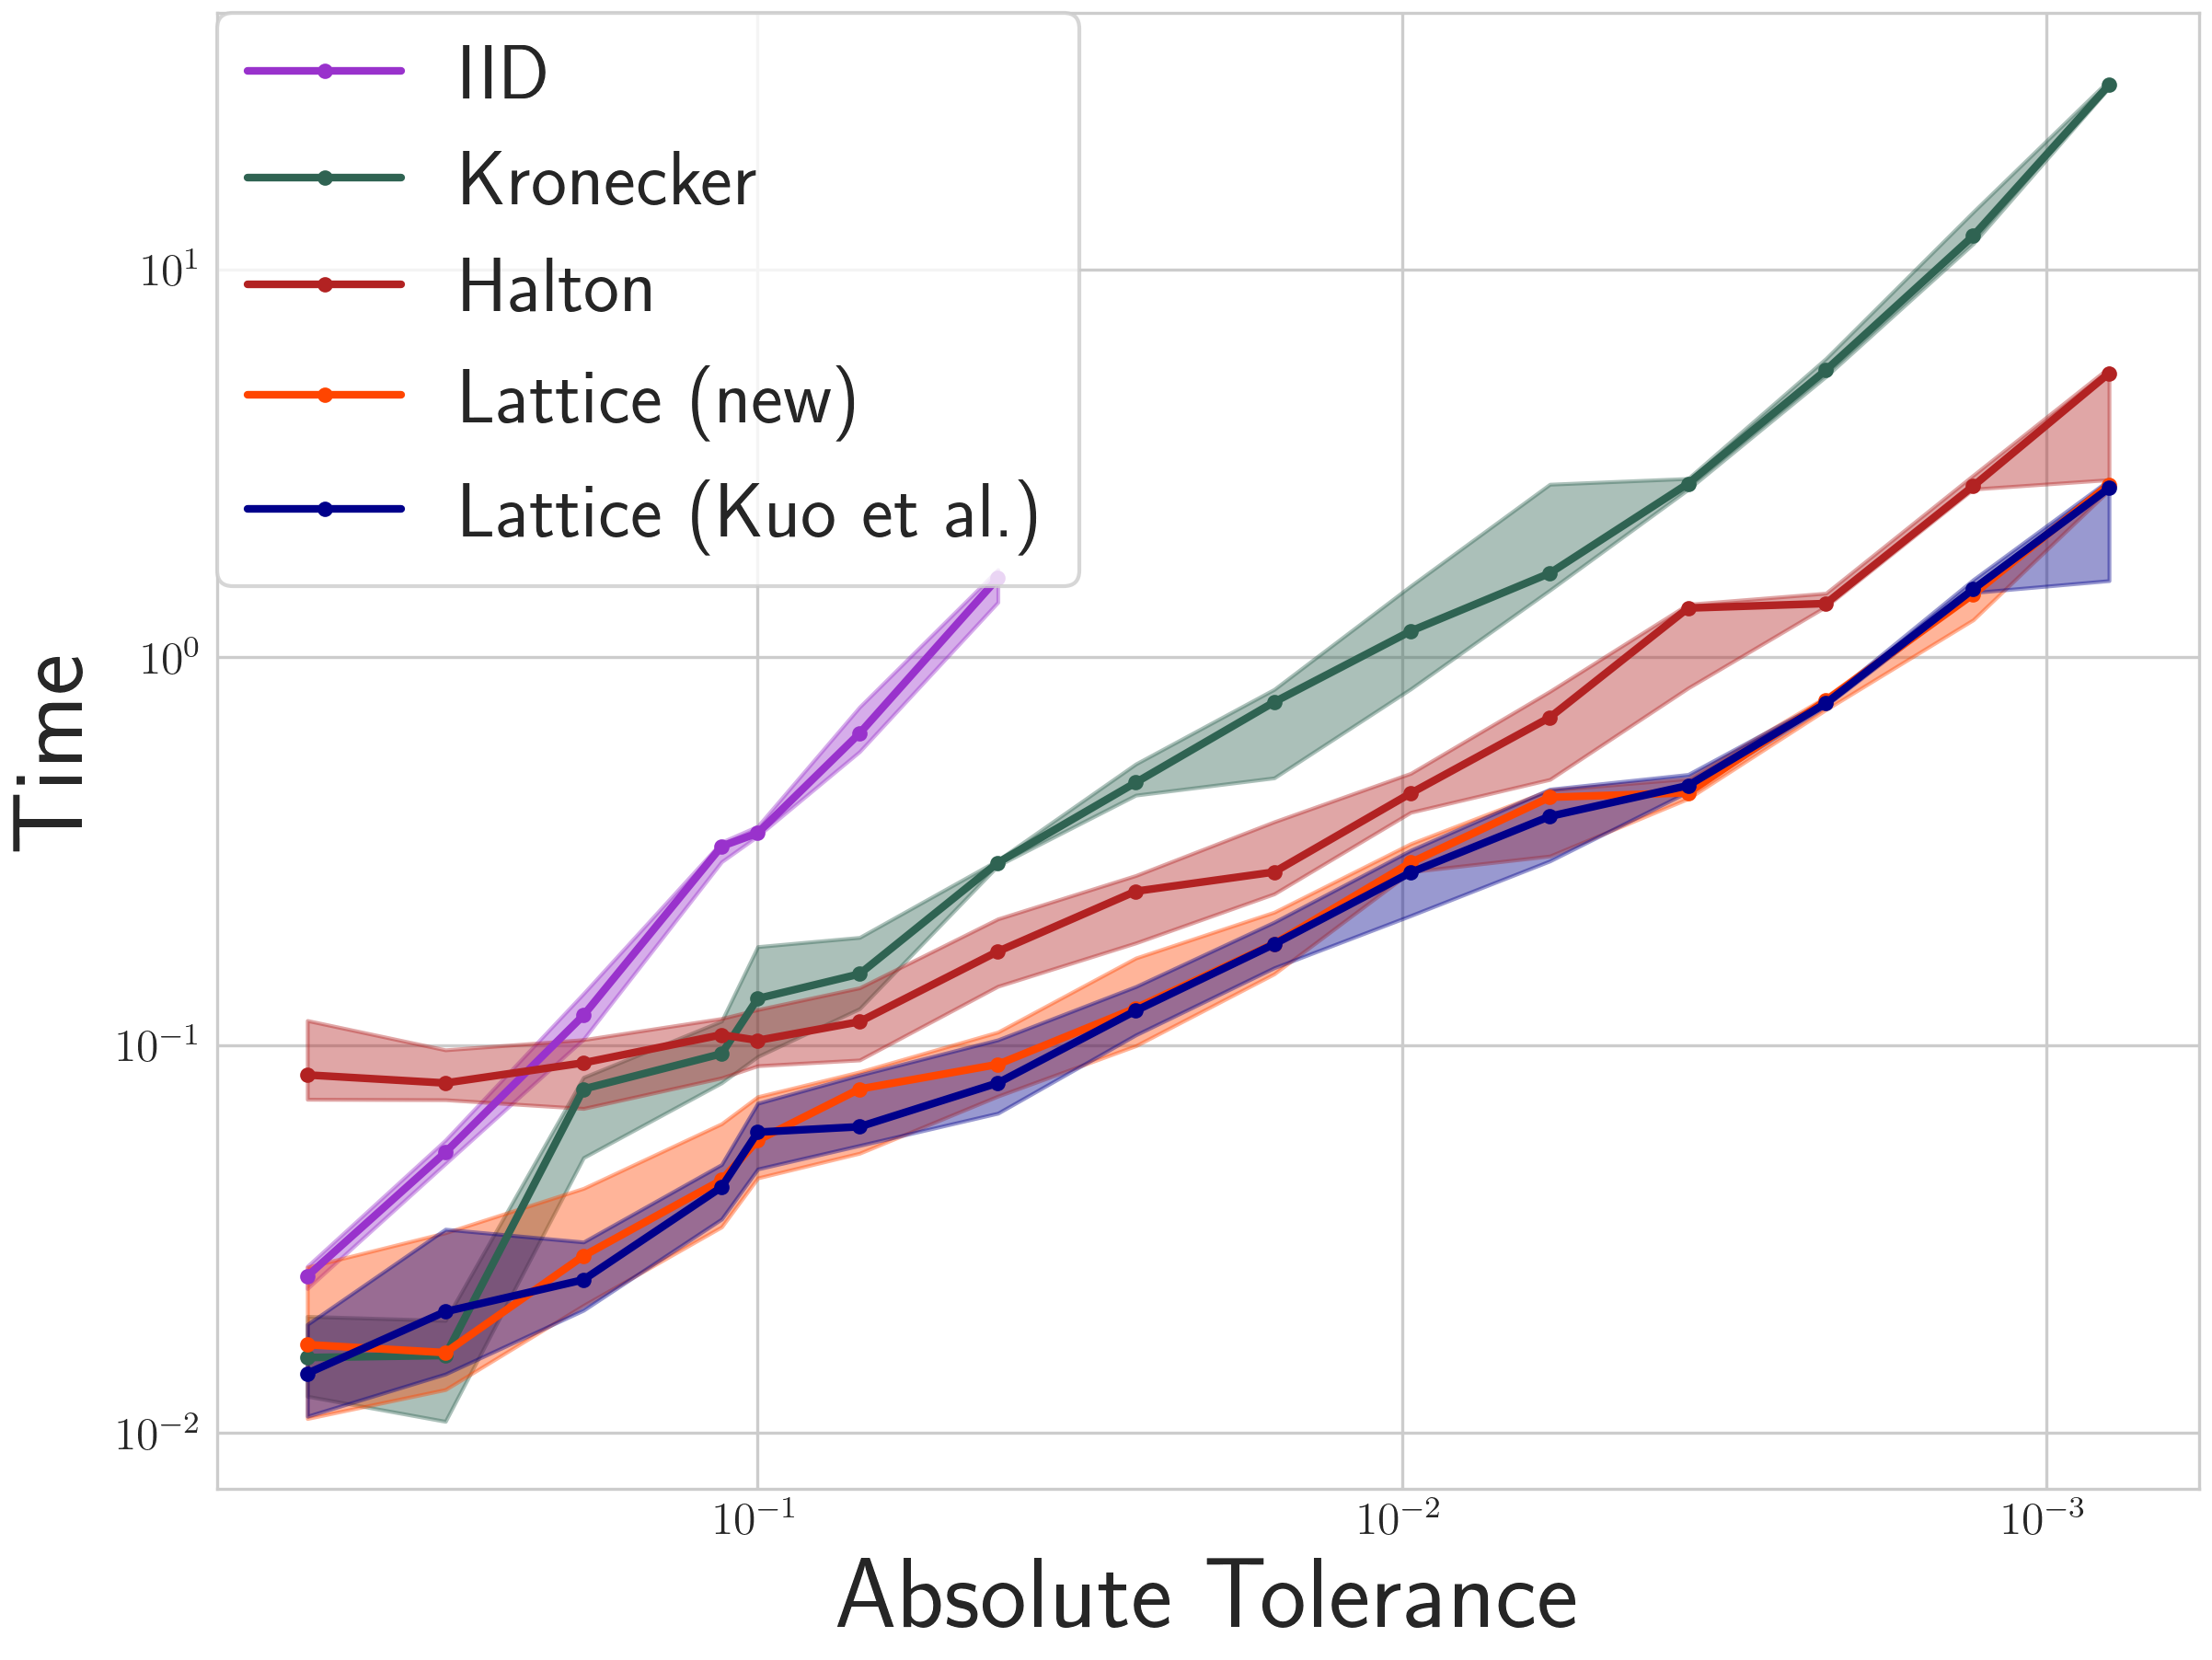

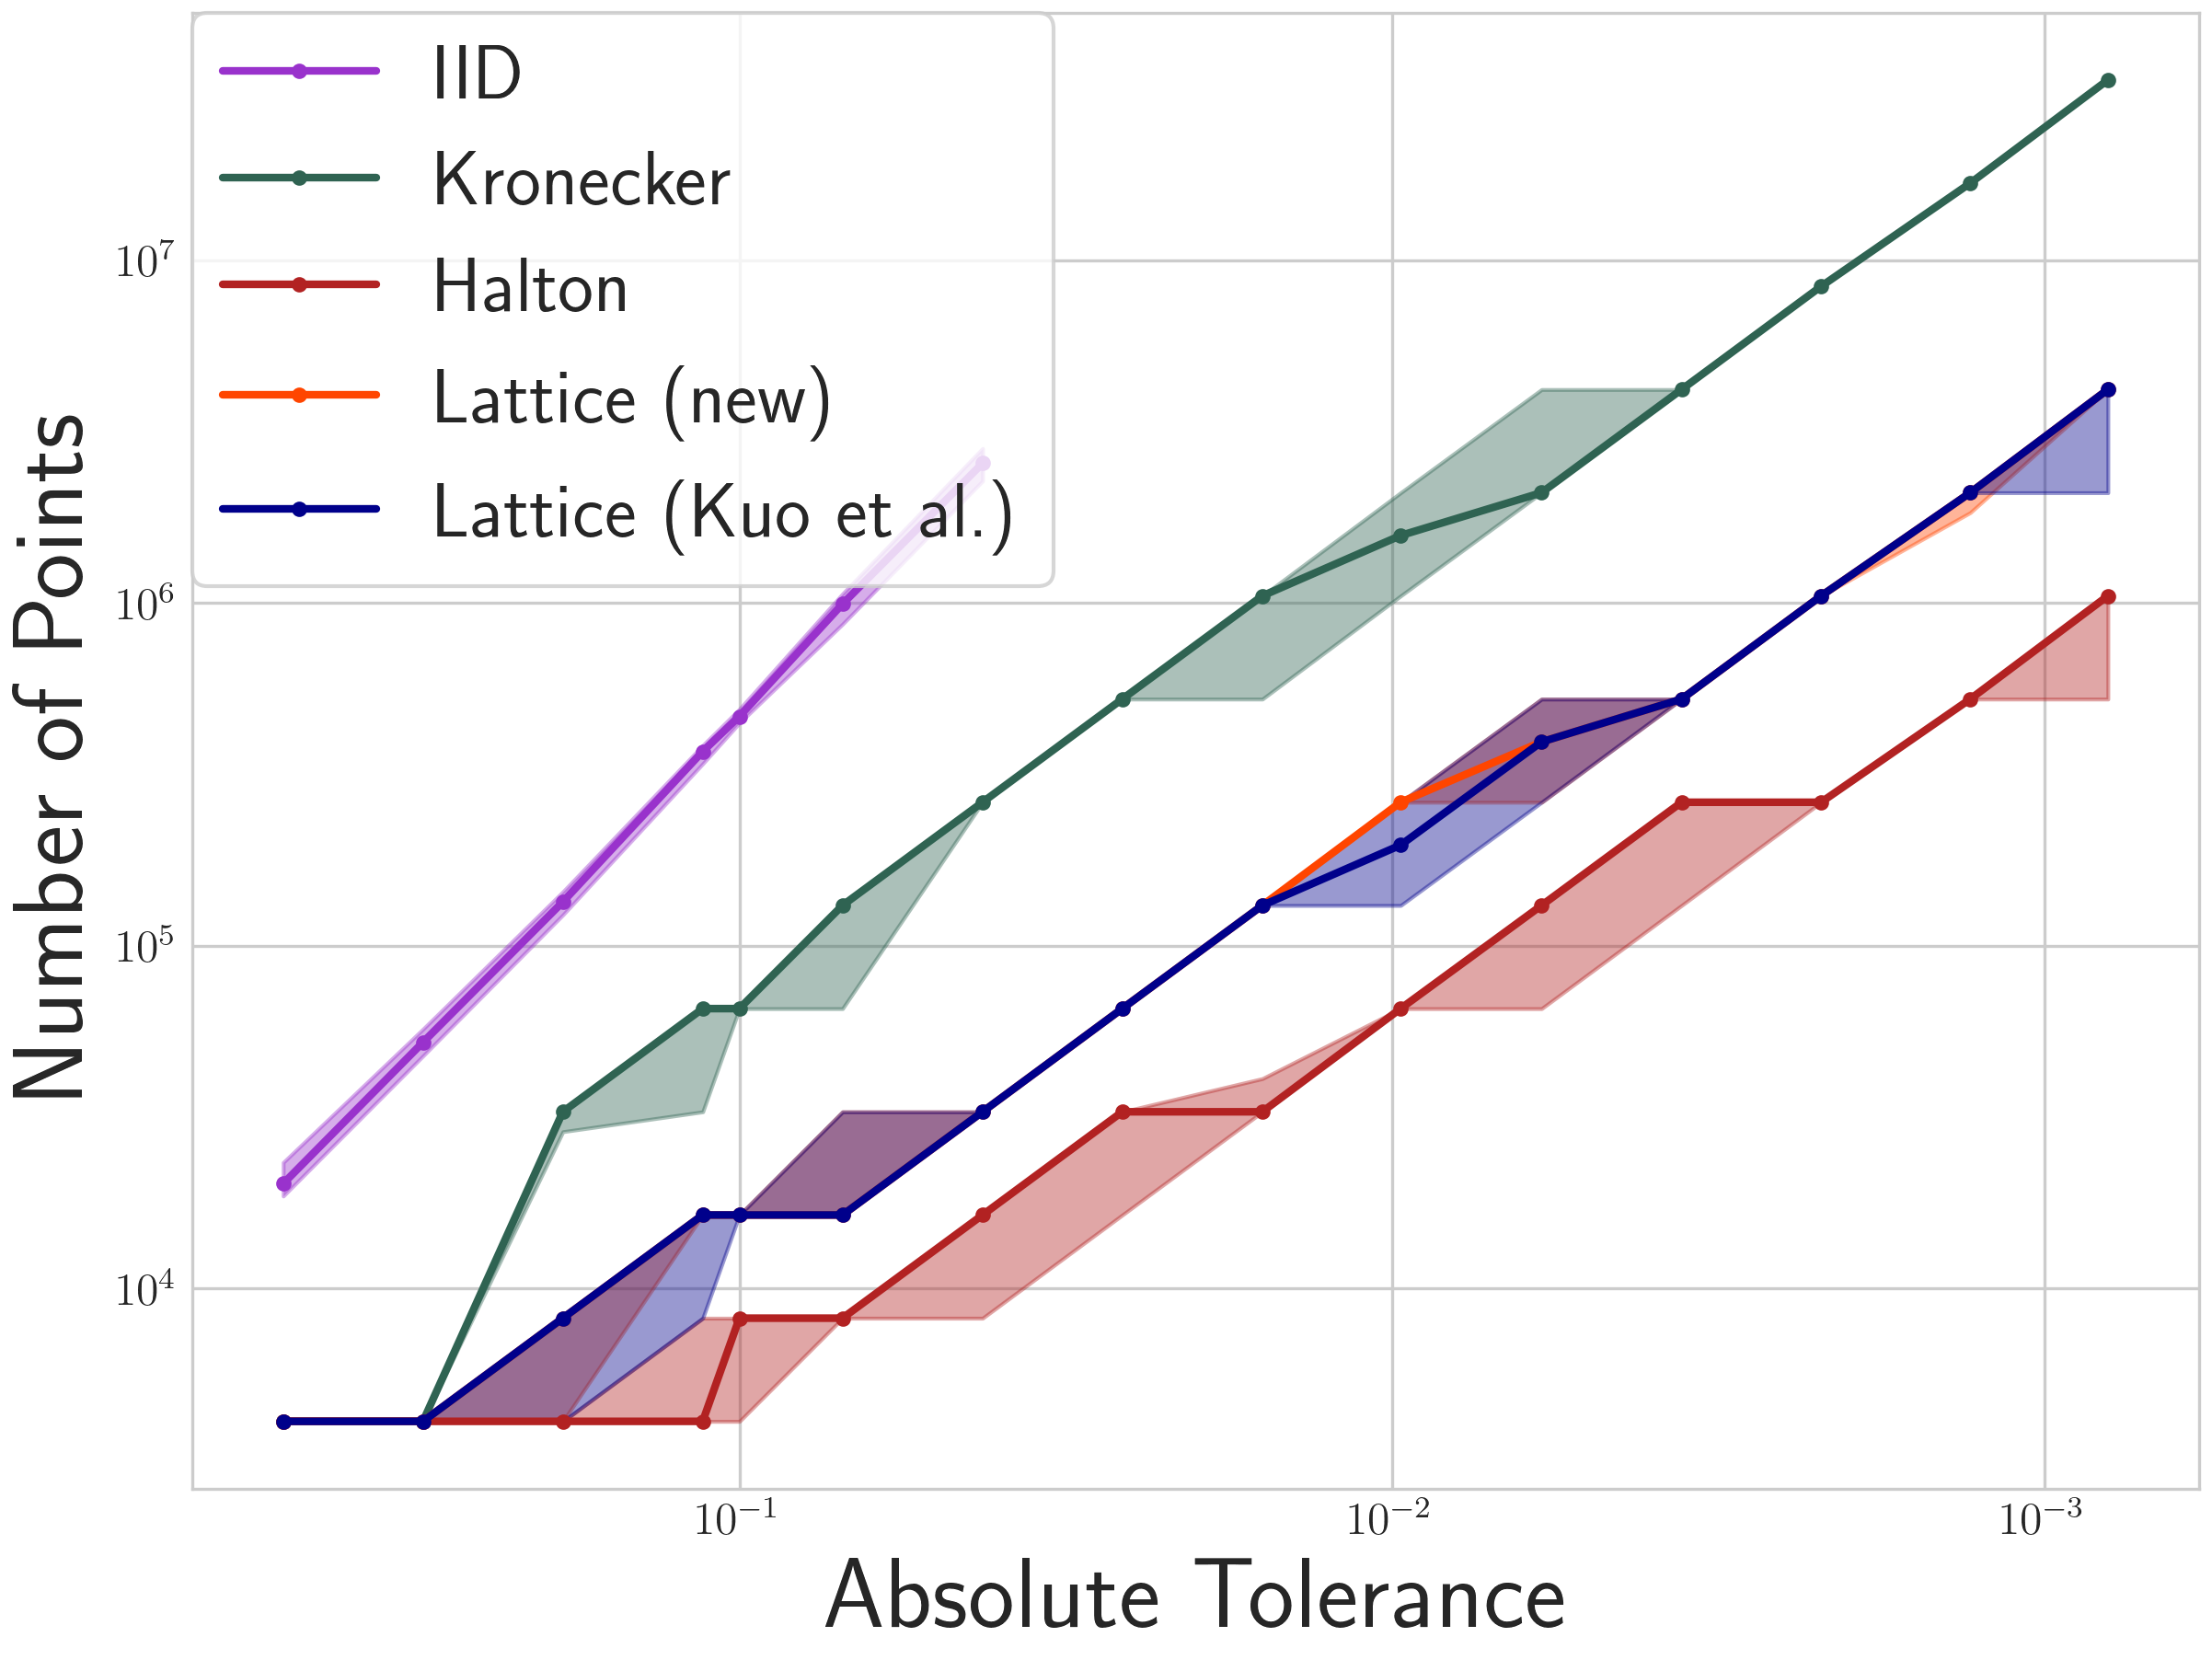

In [42]:
fig = plot_graph(times, iid_times, 'Time', legend_size)[0]
save_figure('asian_option/times', fig)

fig = plot_graph(samples, iid_samples, 'Number of Points', legend_size)[0]
save_figure('asian_option/samples', fig)